In [5]:
%matplotlib inline
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import glob
from pprint import pprint
import copy

from omnigloter import analyse_network as analysis


In [6]:
def cc(in_vs):
    inter = []
    intra = []
    classes = sorted(in_vs.keys())
    n_class = len(classes)
    n_s = len(in_vs[classes[0]])
    tot = n_s * n_class
    corrs = np.ones((tot, tot)) * np.nan
    for j0, c0 in enumerate(classes):
        for j1, c1 in enumerate(classes):
            if j1 < j0:
                continue
            for i0, s0 in enumerate(in_vs[c0]):
                for i1, s1 in enumerate(in_vs[c1]):
                    
                    if i1 < i0:
                        continue
                    def_c = 0. if j0 == j1 else 1.

                    w0 = np.dot(s0, s0)
                    w1 = np.dot(s1, s1)
                    w = np.sqrt(w0 * w1)
                    c = np.correlate(s0, s1)[0]
                    
                    c = (c / w if w > 0. else def_c)
                    
                    if j0 == j1 and i0 != i1:
                        intra.append(c)
                    elif j0 != j1:
                        inter.append(c)

                    row = j0 * n_s + i0
                    col = j1 * n_s + i1
#                     print(j0, j1, i0, i1, row, col)
                    corrs[row, col] = c
                    corrs[col, row] = c

                    row = j0 * n_s + i1
                    col = j1 * n_s + i0
                    corrs[row, col] = c
                    corrs[col, row] = c                
                    
    return corrs, intra, inter

def act_per_samp_to_dict(aps, labels, n_out):
    cls = np.unique(labels)
    vs = {c: [] for c in cls}
    
    for i, l in enumerate(labels):
        v = np.zeros(n_out)
        v[aps[i]] = 1.
        vs[l].append(v)

    return vs



def expand_cross(in_img, n_class):
    out_shape = np.asarray(in_img.shape) + n_class
    out = np.ones(out_shape) * np.nan
    print(out_shape)
    n_samp = in_img.shape[0] // n_class
    for r in range(n_class):
        for c in range(n_class):
            sri = r * n_samp
            eri = sri + n_samp
            
            sci = c * n_samp
            eci = sci + n_samp
            
            
            sro = sri + r
            ero = sro + n_samp
            
            sco = sci + c
            eco = sco + n_samp
            
            out[sro:ero, sco:eco] = in_img[sri:eri, sci:eci]
    return out
            
def target_frequency_error(target, spikes, power=1):
    err = []
    if power == 1:
        err[:] = [np.abs(len(times) - target) for times in spikes]
    else:
        err[:] = [np.abs(len(times) - target)**power for times in spikes]

    return np.sum(err)

def mean_target_frequency_error(target, spikes, power=1):
    return target_frequency_error(target, spikes, power) / float(len(spikes))

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def to_dict(npz):
    d = {}
    for k in npz:
        try:
            d[k] = npz[k].item()
        except:
            d[k] = npz[k]
    return d

def get_test_label_idx(data):
    n_class = data['params']['sim']['num_classes']
    n_train_per_class = data['params']['sim']['samples_per_class']
    n_epochs = data['params']['sim']['num_epochs']
    return n_class * n_train_per_class * n_epochs

def get_test_start_t(data):
    dt = data['params']['sim']['sample_dt']
    n_train = get_test_label_idx(data)
    return n_train * dt

def get_test_spikes_and_labels(data):
    spk = data['recs']['output'][0]['spikes']
    lbl = data['input']['labels']
    dt = data['params']['sim']['sample_dt']
    start_t = get_test_start_t(data)
    start_idx = get_test_label_idx(data)
    out_spk = []
    out_ids = lbl[start_idx:]
    for times in spk:
        ts = np.asarray(times)
        whr = np.where(ts >= start_t)
        out_spk.append(ts[whr])
    return out_spk, out_ids
        
DEF_MARKERS = ['v', '<', 'o', 's', 'P', '*', 'X', 'd', 'p'] * 2
cmap = matplotlib.cm.get_cmap('gist_rainbow')
DEF_COLORS = [cmap(v) for v in np.arange(0., 1., 1./20.)]
# ACTIVITY_THRESHOLD = 0.2 * NUM_OUTPUT
# ABOVE_THRESH_W = 0.5 / NUM_CLASSES
# MAX_VECTOR_DIST = 200.0

def vectors_above_threshold(vectors, threshold):
    vs = [np.sum(v) for v in vectors]
#     print(vs, threshold)
    return [i for i, s in enumerate(vs) if s >= threshold]

def plot_test_map(labels, spikes, start_t, dt, ms=1, markers=DEF_MARKERS, 
                  colors=DEF_COLORS, edgewidth=1):
    unique = np.unique(labels)
    counts = {k: 0 for k in unique}
    
    n_lbl = unique.size
    lw = np.ceil(np.sqrt(n_lbl))
    dlw = 0.8/lw
    n_out = len(spikes)
    w = np.ceil(np.sqrt(n_out))
    
    for x in np.arange(w+1):
        plt.axvline(x, linewidth=1, color='gray')
        plt.axhline(x, linewidth=1, color='gray')

    for nid, times in enumerate(spikes): 
        y = nid // w
        x = nid % w
        for t in times:
            lbl_idx = int((t - start_t) // dt)
            if lbl_idx >= len(labels):
                continue
            lbl = labels[lbl_idx]
            mrk = markers[lbl]
            ly = 0.1 + (lbl // lw) * dlw
            lx = 0.1 + (lbl % lw) * dlw
            lgd = "{:02d}".format(lbl) if counts[lbl] == 0 else None 
            clr = colors[lbl]
            counts[lbl] += 1
            plt.plot(x + lx, y + ly, linestyle='none', color=clr, marker=mrk, 
                     markersize=ms, label=lgd, markeredgewidth=edgewidth, 
                     markeredgecolor='black')
            
    handles, labels = plt.gca().get_legend_handles_labels()
    slbls, shdls = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    plt.legend(shdls, slbls, bbox_to_anchor=(1.01, 1.01))

def plot_test_map_single(labels, spikes, start_t, dt, ms=1, 
                         markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1):
    unique = np.unique(labels)
    counts = {k: 0 for k in unique}
    
    n_lbl = unique.size
    lw = np.ceil(np.sqrt(n_lbl))
    dlw = 0.8/lw
    n_out = len(spikes)
    w = np.ceil(np.sqrt(n_out))

    lbls_per_nrn = get_labels_per_neuron(labels, spikes, start_t, dt)
    ax = plt.gca()
    ax.set_title('Categories (symbol/color) per neuron (squares)')
    for x in np.arange(w+1):
        plt.plot([x, x], [0, w], '-', linewidth=1, color='gray')
        plt.plot([0, w], [x, x], '-', linewidth=1, color='gray')
#         plt.axvline(x, linewidth=1, color='gray')
#         plt.axhline(x, linewidth=1, color='gray')
    unique_neurons = []
    for nid, times in enumerate(spikes): 
        y = nid // w
        x = nid % w
        many = False
        unique_lbl_p_nrn = np.unique(lbls_per_nrn[nid])
        if len(unique_lbl_p_nrn) > 1:
            many = True
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), 1, 1, linewidth=1,
                    edgecolor='black', facecolor='red', alpha=0.3,
                    fill=True, hatch='x')

            # Add the patch to the Axes
            ax.add_patch(rect)
#             continue
        elif len(unique_lbl_p_nrn) == 1:
            unique_neurons.append([nid, unique_lbl_p_nrn[0]])
            many = False
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), 1, 1, linewidth=0,
                    edgecolor='none', facecolor='green', alpha=0.3)

            # Add the patch to the Axes
            ax.add_patch(rect)
#             continue

        for t in times:
            lbl_idx = int((t - start_t) // dt)
            if lbl_idx >= len(labels):
                continue
                
            lbl = labels[lbl_idx]
            mrk = markers[lbl]
            ly = 0.1 + (lbl // lw) * dlw
            lx = 0.1 + (lbl % lw) * dlw
            lgd = "{:02d}".format(lbl) if counts[lbl] == 0 and not many else None 
            clr = colors[lbl]
            if not many:
                counts[lbl] += 1
            plt.plot(x + lx, y + ly, linestyle='none', color=clr, marker=mrk, 
                     markersize=ms, label=lgd, markeredgewidth=edgewidth, 
                     markeredgecolor='black')
    
    try:
        handles, labels = plt.gca().get_legend_handles_labels()
        slbls, shdls = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.legend(shdls, slbls, bbox_to_anchor=(1.01, 1.01))
    except:
        print("all neurons where activated by many classes")

    ax.set_xlim(0, w)
    ax.set_ylim(0, w)
    
    _ticks = 0.5 + np.arange(w)
    ax.set_yticks(_ticks)
    ax.set_yticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    ax.set_xticks(_ticks)
    ax.set_xticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    
    ax.set_xlabel(r'Neuron "$x \;coordinate$"')
    ax.set_ylabel(r'Neuron "$y \;coordinate$"')
    
    return unique_neurons
    
def get_labels_per_neuron(labels, spikes, start_t, dt):
    lbls_per_nrn = {k: [] for k in range(len(spikes))}

    for nid, times in enumerate(spikes):
        ts = np.asarray(times)
        ts = ts[np.where(ts >= start_t)]
        ts = ts.astype('int')
        ts -= int(start_t)
        ts //= int(dt)
#         ids = ts[np.where(ts < len(labels))]
        ids = ts
        for lbl in [labels[i] for i in ids]:
            lbls_per_nrn[nid].append(lbl)
    return lbls_per_nrn

def get_neurons_per_label(labels, spikes, start_t, dt):
    unique = np.unique(labels)
    nrns_per_lbl = {k: [] for k in unique}
    for nid, times in enumerate(spikes):
        ts = np.asarray(times).astype('int')
        ts -= int(start_t)
        ts //= int(dt)
        ids = ts[np.where(ts < len(labels))]
        for lbl in [labels[i] for i in ids]:
            nrns_per_lbl[lbl].append(nid)

    return nrns_per_lbl

def mean_per_sample_class_distance(_activity_per_sample, labels, n_out):
    return np.mean(
        per_sample_class_distance(_activity_per_sample, labels, n_out))

def per_sample_class_distance(_activity_per_sample, labels, n_out):
    class_samples = {}
    max_active = 0
    for idx, lbl in enumerate(labels):
        lbl_list = class_samples.get(lbl, [])
        lbl_list.append( _activity_per_sample[idx])
        class_samples[lbl] = lbl_list
        
        if len(_activity_per_sample[idx]) > max_active:
            max_active = len(_activity_per_sample[idx])

    if max_active == 0:
        return 0
    
    v0 = np.zeros(n_out)
    v1 = np.zeros(n_out)
    dists = []
    classes = sorted(class_samples.keys())
    for idx0, cls0 in enumerate(classes[:-1]):
        for cls1 in classes[idx0+1:]:
            for samp0 in class_samples[cls0]:
                v0[:] = 0
                if len(samp0):
                    v0[samp0] = 1
                for samp1 in class_samples[cls1]:
                    v1[:] = 0
                    if len(samp1):
                        v1[samp1] = 1
                    
                    dists.append( np.sum(np.abs(v0 - v1)) )

    return dists

def error_sample_target_activity(target, activity_per_sample):
    act = np.asarray([len(ids) for ids in activity_per_sample])
    return np.sum(np.abs(act - target))


def activity_per_sample(labels, spikes, start_t, dt):
    end_t = start_t + len(labels) * dt
    aps = [[] for _ in labels]
    for st in np.arange(start_t, end_t, dt):
        et = st + dt
        idx = int((st - start_t) // dt)
        for nid, times in enumerate(spikes):
            ts = np.asarray(times)
            whr = np.where(np.logical_and(st <= ts, ts < et))[0]
            if len(whr):
                aps[idx].append(nid)
    return aps


def get_max_t(spikes):
    max_t = -1
    max_id = -1
    for nid, times in enumerate(spikes):
        if len(times):
            local_max_t = np.max(times)
            if local_max_t > max_t:
                max_t = local_max_t
                max_id = nid
    return max_t, max_id


def get_vectors(neurons_per_label):
    vectors = {}
    for k in neurons_per_label:
        v = np.zeros(len(out_spikes))
        v[neurons_per_label[k]] = 1.
        vectors[k] = v
    return vectors

def mdist(v0, v1, normalize=True):
    s = 0.
    if np.sum(v0) >= 1 and np.sum(v1) >= 1:
        s = np.sum(np.abs(v0 - v1))
        if normalize:
            s *= 1./(np.sum(v0) + np.sum(v1))
    return s

def get_distances(neurons_per_label):
    n_labels = len(neurons_per_label)
    vectors = get_vectors(neurons_per_label)
    dists = np.zeros((n_labels, n_labels))
    labels = sorted(neurons_per_label.keys())
    for k0 in labels[:-1]:
        for k1 in labels[k0+1:]:
            s = mdist(vectors[k0], vectors[k1])
                
            dists[k0, k1] = s
            dists[k1, k0] = dists[k0, k1]

    return dists


def mht(a, b):
    return np.sum(np.abs(a - b))


def max_dist(vecs):
    max_d = -1
    for i, v0 in enumerate(vecs[:-1]):
        for v1 in vecs[i+1:]:
            d = mht(v0, v1)
            if d > max_d:
                max_d = d
    return max_d

def empty(st, dt, spikes):
    for ts in spikes:
        ts = np.asarray(ts)
        whr = np.where(np.logical_and(st <= ts, ts < st + dt))[0]
        if len(whr):
            return False
    return True

def high_rate(start_t, spikes, rate_threshold):
    ids = []
    rates = []
    for nid, ts in enumerate(spikes):
        ts = np.asarray(ts)
        whr = np.where(start_t <= ts)[0]
        if len(whr) >= rate_threshold:
            ids.append(nid)
            rates.append(len(whr))

    return ids, rates

def average_rate(start_t, spikes):
    rates = []
    for nid, ts in enumerate(spikes):
        ts = np.asarray(ts)
        ts = ts[np.where(start_t <= ts)]
        rates.append(len(ts))
    return np.mean(rates)


def sort_activity_per_sample(labels, act_per_sample):
    classes = sorted(np.unique(labels))
    d = {k: [] for k in classes}
    for i, l in enumerate(labels):
        d[l].append(act_per_sample[i])
    
    saps = []
    for c in classes:
        saps += d[c]
    return saps

    
def bin_spikes(spikes, dt, start_t, end_t):
    bins = np.arange(start_t, end_t, dt)
    
    bs = [[[] for _ in range(len(spikes))] 
              for _ in np.arange(start_t, end_t, dt)]

    for i, times in enumerate(spikes):
        inds = np.digitize(times, bins)
        for j in range(len(times)):
            b = inds[j] - 1
            bs[b][i].append(times[j])
    return bs


def norm_rate(binned_spikes, total=False):
    w = 1./len(spikes)
    rate = [0. for _ in binned_spikes]
    for i, bs in enumerate(binned_spikes):
        w = 1./len(bs)
        rate[i] = np.sum([1 if (not total) and len(times) else len(times)
                            for times in bs]) * w
    return rate

def unique_times(bin_spikes, dt):
    rt = [set() for _ in bin_spikes]
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ts = np.asarray(ts)
            rt[i].update(set(ts))
        
    return [np.asarray(list(s)) for s in rt]

def collapse_times(bin_spikes, dt):
    ct = [[] for _ in bin_spikes]
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ct[i] += ts
        
    return ct#[np.asarray(s) for s in ct]

def relative_collapse_times(bin_spikes, dt):
    ct = []
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ct += (np.asarray(ts) - dt * i).tolist()
        
    return ct#[np.asarray(s) for s in ct]



def first_to_spike(ssa):
    min_t = np.inf
    min_n = None
    for n, times in enumerate(ssa):
        if len(times):
            t = np.min(times)
            if t < min_t:
                min_t = t
                min_n = n
    
    mins = []
    for n, times in enumerate(ssa):
        ties = []
        if len(times):
            if np.isclose(np.min(times), min_t):
                mins.append(n)
    if len(mins):
        mins = np.unique(mins).astype('int')
    return mins, min_t
                
        
def first_to_spike_activity_per_sample(test_binned):
    return [first_to_spike(ssa) for ssa in test_binned]
        

def plot_first_to_spike(labels, firsts, n_out, ms=1, 
            markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1):

    unique = np.unique(labels)
    counts = {k: 0 for k in unique}
    
    n_lbl = unique.size
    lw = np.ceil(np.sqrt(n_lbl))
    dlw = 0.8/lw
    w = np.ceil(np.sqrt(n_out))

    lbls_per_nrn = {i: [] for i in range(n_out)}
    for l, fs in zip(labels, firsts):
        for f in fs:
            lbls_per_nrn[f].append(l)
    
    ax = plt.gca()
    ax.set_title('Categories (symbol/color) per neuron (squares)')
    for x in np.arange(w+1):
        plt.plot([x, x], [0, w], '-', linewidth=1, color='gray')
        plt.plot([0, w], [x, x], '-', linewidth=1, color='gray')
#         plt.axvline(x, linewidth=1, color='gray')
#         plt.axhline(x, linewidth=1, color='gray')
    unique_neurons = []
    for i, nids in enumerate(firsts):
        lbl = labels[i]
        clr = colors[lbl]
        mrk = markers[lbl]

        for nid in nids:
            y = nid // w
            x = nid % w
            many = False
            unique_lbl_p_nrn = np.unique(lbls_per_nrn[nid])
            if len(unique_lbl_p_nrn) > 1:
                many = True
                # Create a Rectangle patch
                rect = patches.Rectangle((x, y), 1, 1, linewidth=1,
                        edgecolor='black', facecolor='red', alpha=0.3,
                        fill=True, hatch='x')

                # Add the patch to the Axes
                ax.add_patch(rect)
    #             continue
            elif len(unique_lbl_p_nrn) == 1:
#                 print("first label_i {}, label {}, neuron {}, x {}, y {}".format(i, lbl, nid, x, y))
                unique_neurons.append([nid, unique_lbl_p_nrn[0]])
                many = False
                # Create a Rectangle patch
                rect = patches.Rectangle((x, y), 1, 1, linewidth=0,
                        edgecolor='none', facecolor='green', alpha=0.3)

                # Add the patch to the Axes
                ax.add_patch(rect)
    #             continue
            else:
                continue

            ly = 0.1 + (lbl // lw) * dlw
            lx = 0.1 + (lbl % lw) * dlw
            lgd = "{:02d}".format(lbl) if counts[lbl] == 0 and not many else None 

            if not many:
                counts[lbl] += 1
            plt.plot(x + lx, y + ly, linestyle='none', color=clr, marker=mrk, 
                     markersize=ms, label=lgd, markeredgewidth=edgewidth, 
                     markeredgecolor='black')
    
    try:
        handles, labels = plt.gca().get_legend_handles_labels()
        slbls, shdls = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.legend(shdls, slbls, bbox_to_anchor=(1.01, 1.01))
    except:
        print("all neurons where activated by many classes")

    ax.set_xlim(0, w)
    ax.set_ylim(0, w)
    
    _ticks = 0.5 + np.arange(w)
    ax.set_yticks(_ticks)
    ax.set_yticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    ax.set_xticks(_ticks)
    ax.set_xticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    
    ax.set_xlabel(r'Neuron "$x \;coordinate$"')
    ax.set_ylabel(r'Neuron "$y \;coordinate$"')
    
    return unique_neurons


def plot_test_map_single(labels, spikes, start_t, dt, ms=1, 
                         markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1):
    unique = np.unique(labels)
    counts = {k: 0 for k in unique}
    
    n_lbl = unique.size
    lw = np.ceil(np.sqrt(n_lbl))
    dlw = 0.8/lw
    n_out = len(spikes)
    w = np.ceil(np.sqrt(n_out))

    lbls_per_nrn = get_labels_per_neuron(labels, spikes, start_t, dt)
    ax = plt.gca()
    ax.set_title('Categories (symbol/color) per neuron (squares)')
    for x in np.arange(w+1):
        plt.plot([x, x], [0, w], '-', linewidth=1, color='gray')
        plt.plot([0, w], [x, x], '-', linewidth=1, color='gray')
#         plt.axvline(x, linewidth=1, color='gray')
#         plt.axhline(x, linewidth=1, color='gray')
    unique_neurons = []
    for nid, times in enumerate(spikes): 
        y = nid // w
        x = nid % w
        many = False
        unique_lbl_p_nrn = np.unique(lbls_per_nrn[nid])
        if len(unique_lbl_p_nrn) > 1:
            many = True
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), 1, 1, linewidth=1,
                    edgecolor='black', facecolor='red', alpha=0.3,
                    fill=True, hatch='x')

            # Add the patch to the Axes
            ax.add_patch(rect)
#             continue
        elif len(unique_lbl_p_nrn) == 1:
            unique_neurons.append([nid, unique_lbl_p_nrn[0]])
            many = False
            # Create a Rectangle patch
            rect = patches.Rectangle((x, y), 1, 1, linewidth=0,
                    edgecolor='none', facecolor='green', alpha=0.3)

            # Add the patch to the Axes
            ax.add_patch(rect)
#             continue

        for t in times:
            lbl_idx = int((t - start_t) // dt)
#             if lbl_idx >= len(labels):
#                 continue
                
            lbl = labels[lbl_idx]
            mrk = markers[lbl]
            ly = 0.1 + (lbl // lw) * dlw
            lx = 0.1 + (lbl % lw) * dlw
            lgd = "{:02d}".format(lbl) if counts[lbl] == 0 and not many else None 
            clr = colors[lbl]
            if not many:
#                 print("rate label_i {}, label {}, neuron {}, x {}, y {}".format(lbl_idx, lbl, nid, x, y))
                counts[lbl] += 1
            plt.plot(x + lx, y + ly, linestyle='none', color=clr, marker=mrk, 
                     markersize=ms, label=lgd, markeredgewidth=edgewidth, 
                     markeredgecolor='black')
    
    try:
        handles, labels = plt.gca().get_legend_handles_labels()
        slbls, shdls = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        plt.legend(shdls, slbls, bbox_to_anchor=(1.01, 1.01))
    except:
        print("all neurons where activated by many classes")

    ax.set_xlim(0, w)
    ax.set_ylim(0, w)
    
    _ticks = 0.5 + np.arange(w)
    ax.set_yticks(_ticks)
    ax.set_yticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    ax.set_xticks(_ticks)
    ax.set_xticklabels([f"{i: 2d}" for i in np.arange(w, dtype='int')])
    
    ax.set_xlabel(r'Neuron "$x \;coordinate$"')
    ax.set_ylabel(r'Neuron "$y \;coordinate$"')
    
    return unique_neurons


In [3]:
data_path = "../titan"
file_names = sorted( glob.glob(os.path.join(data_path, 'data_gen*npz')), reverse=True )
# data = to_dict( np.load(file_names[3]) )
data = to_dict( np.load(file_names[0], allow_pickle=True) )
print(data.keys())
sim_ps = data['params']['sim']
pprint(sim_ps)
print(data['correlations'])

dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'database': ['Futurama'],
 'duration': 14000.0,
 'input_divs': (3, 5),
 'input_layers': 4,
 'input_shape': (56, 56),
 'kernel_pad': 3,
 'kernel_width': 7,
 'noisy_spikes_path': '/its/home/gp283/l2l-omniglot/L2L-OMNIGLOT',
 'num_classes': 14,
 'num_epochs': 1,
 'num_sims': 1,
 'on_juwels': False,
 'output_size': 280,
 'prob_noise': 0.0,
 'sample_dt': 50.0,
 'samples_per_class': 16,
 'spikes_path': '/its/home/gp283/omniglot_output_56',
 'steps': 1,
 'test_per_class': 4,
 'total_per_class': 20,
 'use_gabor': False}
{'output': array([[1.        , 0.09284767, 0.13470398, ..., 0.08703883, 0.13055824,
        0.        ],
       [0.09284767, 1.        , 0.        , ..., 0.12930164, 0.03232541,
        0.06565322],
       [0.13470398, 0.        , 1.        , ..., 0.18759162, 0.15632635,
        0.15875016],
       ...,
       [0.08703883, 0.12930164, 0.

In [4]:
sim_ps = data['params']['sim']
dt = sim_ps['sample_dt']
n_class = sim_ps['num_classes']
n_test = sim_ps['test_per_class'] * n_class

spikes = data['recs']['output'][0]['spikes']
labels = data['input']['labels']

n_out = len(spikes)
out_per_class = n_out // n_class

start_t = get_test_label_idx(data) * dt
end_t = start_t + n_test *  dt
out_spikes, out_labels = get_test_spikes_and_labels(data)
apc, ipc = analysis.spiking_per_class(labels, spikes, start_t, end_t, dt)

In [5]:
act_per_samp = activity_per_sample(out_labels, out_spikes, start_t, dt)

punish_activity = error_sample_target_activity(target=out_per_class, activity_per_sample=act_per_samp)
reward_distance = mean_per_sample_class_distance(act_per_samp, out_labels, n_out)

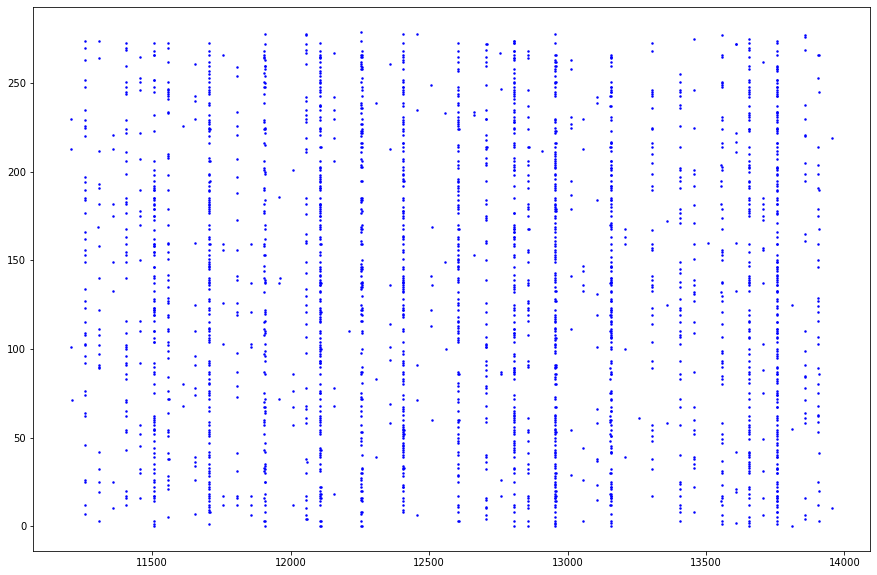

In [6]:
# plt.close('all')
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1)

for idx, ts in enumerate(out_spikes):
    plt.plot(ts, np.ones_like(ts) * idx, '.b', 
            markersize=5, markeredgewidth=0)

# ts = (np.arange(len(out_labels)) + get_test_label_idx(data)) * dt
# n_ts = float(ts.size)
# n_out = len(out_spikes)
# lbl_y = n_out + 5
# for idx, t in enumerate(ts):
#     lbl = out_labels[idx]
#     plt.text(t, lbl_y, "{}".format(lbl))
plt.show()

In [7]:
# plt.figure(figsize=(10, 10))

# plot_test_map(out_labels, out_spikes, start_t, dt, 5)

# plt.show()

In [8]:
labels_per_neuron = get_labels_per_neuron(out_labels, out_spikes, start_t, dt)
not_single = {k: labels_per_neuron[k] for k in labels_per_neuron if len(labels_per_neuron[k]) > 1}
not_single_uni = {k: not_single[k] for k in not_single if len(np.unique(not_single[k])) == 1}
# pprint(not_single)
pprint(not_single_uni)

{209: [3, 3], 275: [10, 10]}


56
4.0
11200.0
2756.0
55.12
[2, 3, 4, 5, 7, 8, 9, 10, 11, 12]
280 14 20.0


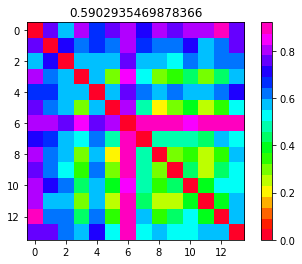

In [9]:
n_out = len(out_spikes)
max_t, max_nid = get_max_t(out_spikes)
print(len(out_labels))
print(len(out_labels)/n_class)
print(start_t)
print(max_t - start_t)
print((max_t - start_t)/dt)
neurons_per_label = get_neurons_per_label(out_labels, out_spikes, start_t, dt)
vectors = [np.zeros(n_out) for _ in neurons_per_label]
for l in neurons_per_label:
    vectors[l][neurons_per_label[l]] = 1
print(vectors_above_threshold(vectors, int(n_out*0.3)))
n_out = len(out_spikes)
n_class = data['params']['sim']['num_classes']
# max_d = n_out/float(n_class)
max_d = 200.#float(n_out - n_class - 1)
print(n_out, n_class, n_out/float(n_class))
dists = get_distances(neurons_per_label) #/ max_d
# vmax = np.sqrt(len(out_spikes))
# vmax = len(out_spikes)/2
# vmax = np.sqrt(2)
vmax = 1.0

# print(colors[0])
unique_d = []
for i in range(dists.shape[0])[:-1]:
    for j in range(i+1, dists.shape[0]):
        unique_d.append(dists[i, j])
# print(unique_d)
# colors = discrete_cmap(int(np.ceil(vmax)), 'gist_rainbow')
# colors = discrete_cmap(int(np.ceil(np.mean(unique_d))), 'gist_rainbow')
colors = discrete_cmap(20, 'gist_rainbow')

plt.figure()
ax = plt.subplot(1, 1, 1)
ax.set_title(np.mean(unique_d))
im = plt.imshow(dists, interpolation='nearest', cmap=colors)#, vmax=vmax)
plt.colorbar(im)
plt.show()

../titan/data_gen0000000000_ind0000000000.npz
280


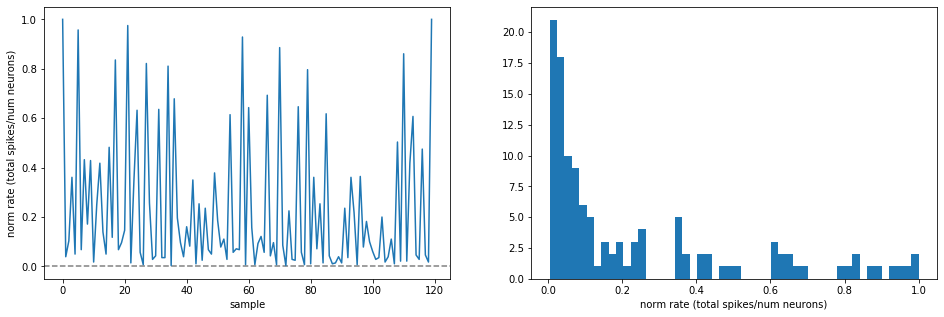

In [18]:
spikes = []
bs = []
rates = []
data = {}
d = '../titan'
for f in sorted(glob.glob(os.path.join(d, 'data*.npz')))[:1]:
    print(f)
    fname = os.path.basename(f)
    with np.load(f, allow_pickle=True) as npz:
#             print(sorted(npz['recs'].item()['mushroom'][0]['spikes'].keys()))
        sim_ps = npz['params'].item()['sim']
        dt = sim_ps['sample_dt']
        n_class = sim_ps['num_classes']
        n_test = sim_ps['test_per_class'] * n_class
        duration = sim_ps['duration']
#         start_t = duration - n_test * dt
#         end_t = start_t + n_test *  dt
        
        start_t = 0
        end_t = 6000#0
        spikes[:] = npz['recs'].item()['output'][0]['spikes']

        print(len(spikes))
#             bs[:] = bin_spikes(spikes, dt, end_t)
        data[fname] = bin_spikes(spikes, dt, start_t,  end_t)
#             rates[:] = norm_rate(bs)

#             plt.figure()
#             ax = plt.subplot(1, 1, 1)
#             ax.set_title(f"{dd}\n{fname}")
#             plt.plot(rates)
#             plt.show()

for ff in data:
    bs = data[ff]
    rates = norm_rate(bs)
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
#     plt.suptitle(f"{ff}")
    plt.axhline(0.0, linestyle='--', color='gray')
    plt.plot(rates)
    ax.set_xlabel('sample')
    ax.set_ylabel('norm rate (total spikes/num neurons)')
#         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

    ax = plt.subplot(1, 2, 2)
    plt.hist(rates, bins=50)
    ax.set_xlabel('norm rate (total spikes/num neurons)')
    plt.savefig(f"hist_rates_{ff}.png", dpi=150)

    plt.show()



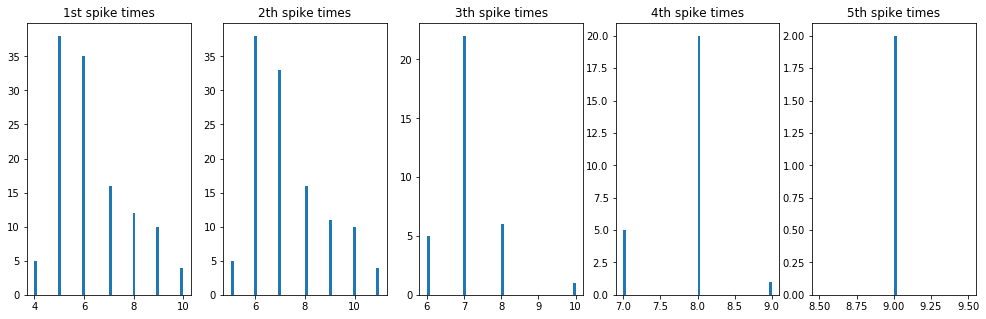

In [11]:
def get_first_n_per_sample(bin_spikes, dt, n=5):
    firsts = [[] for _ in range(n)]
    for i, bs in enumerate(bin_spikes):
        all_ts = set()
        for ts in bs:
            all_ts |= set(ts)
        sorted_ts = np.asarray(sorted(list(all_ts))) - dt * i
        # print(sorted_ts)
        for i, t in enumerate(sorted_ts):
            if i == n:
                break
            firsts[i].append(t)

    return firsts


for ff in data:
    bs = data[ff]
    n = 5
    firsts = get_first_n_per_sample(bs, dt, n)

    plt.figure(figsize=(17, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        place = "st" if i == 0 else "th"
        ax.set_title(f"{i+1}{place} spike times")
        plt.hist(firsts[i], bins=50)

    plt.savefig(f"hist_spike_places.png", dpi=150)
    plt.show()

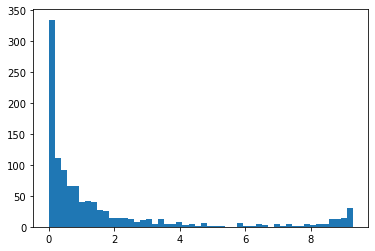

In [13]:
from numpy import random
import matplotlib.pyplot as plt
# import seaborn as sns

lo = random.chisquare(df=1, size=1000)
mx = lo.max()
hi = mx - random.chisquare(df=1, size=100)

plt.figure()
# plt.plot(15 - random.chisquare(df=1, size=1000))
plt.hist(np.append(lo, hi), bins=50)

plt.show() 

In [18]:
14*50

700

00114 ../titan/data_gen*00114_*npz 20
100.0


0: ../titan/data_gen0000000114_ind0000000019.npz
fitness
0.5564192006580174
avg_class_samp_distance
13.681565510530827
avg_activity_error
147.35714285714286
avg_sharing_class_error
157.04
avg_freq_error
30.71
{'A_minus': 4.678974602063293,
 'A_plus': 1.9447310663858468,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.014215101935752936,
 'out_weight': 7.457052478372991,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -321.425577346612
[98 98]
[98 98]
0.4857/0.3330 - 0.4637 = -0.3020
too low sim_fit


1: ../titan/data_gen0000000114_ind0000000018.npz
fitness
0.5985940055091092
avg_class_samp_distance
12.805387533288608
avg_activity_error
170.16071428571428
avg_sharing_class_error
159.55857142857144
avg_freq_error
36.44571428571429
{'A_minus': 6.590226097347989,
 'A_plus': 2.0521083622207312,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob':

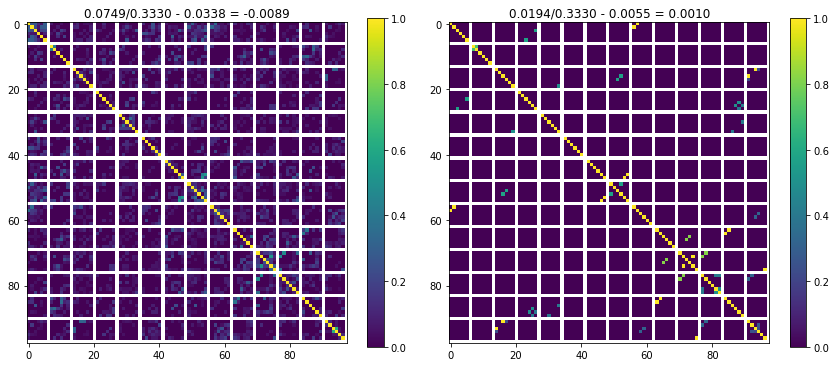

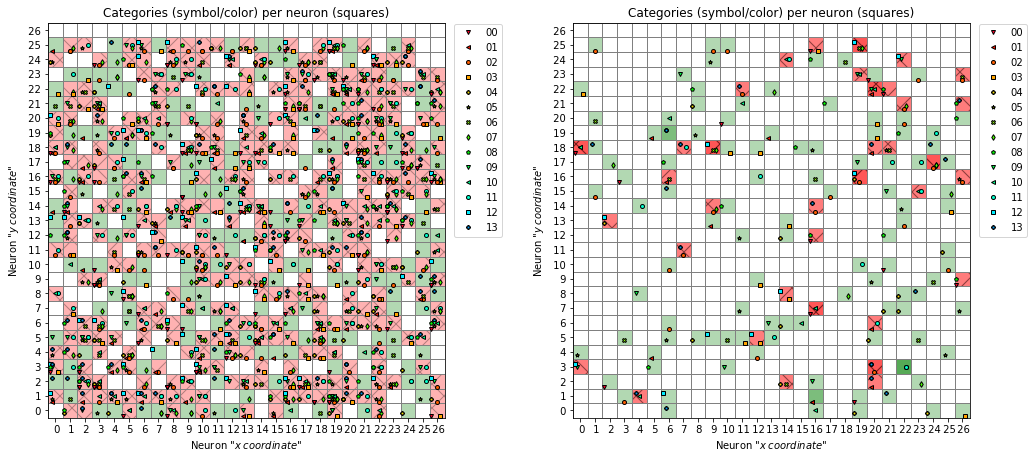



3: ../titan/data_gen0000000114_ind0000000016.npz
fitness
0.08848491071245108
avg_class_samp_distance
6.14610124609007
avg_activity_error
8.476190476190476
avg_sharing_class_error
4.638655462184874
avg_freq_error
0.032857142857142856
{'A_minus': 7.789048470225662,
 'A_plus': 0.03767413882557836,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.02249588158516595,
 'out_weight': 7.451346606403997,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -7.001601835142424
[98 98]
[98 98]
0.0721/0.3330 - 0.0397 = -0.0156


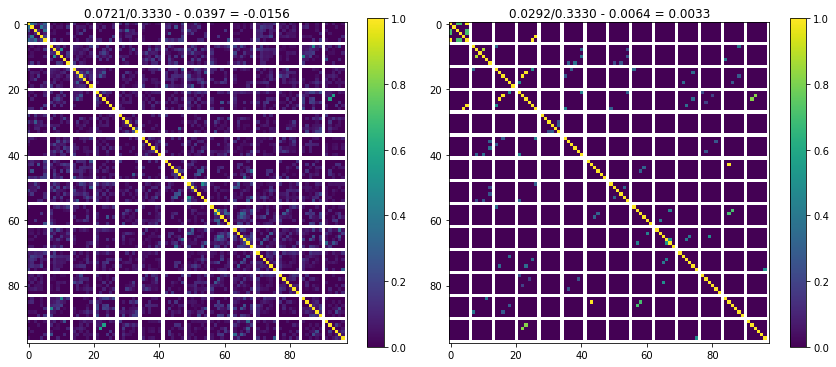

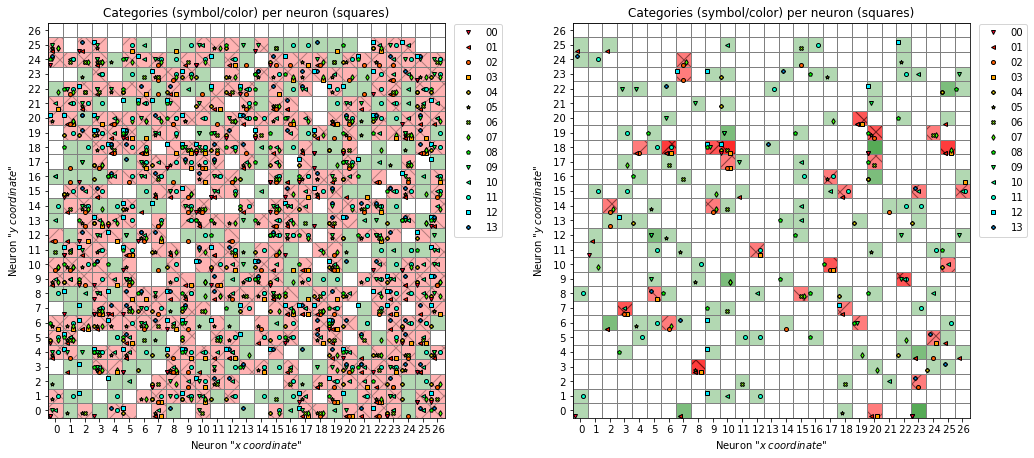



4: ../titan/data_gen0000000114_ind0000000015.npz
fitness
0.5635760078757573
avg_class_samp_distance
13.293726666378944
avg_activity_error
159.1904761904762
avg_sharing_class_error
158.27
avg_freq_error
33.642857142857146
{'A_minus': 1.3926434343114578,
 'A_plus': 9.704996685217317,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.48257256403648036,
 'out_weight': 7.873582400571403,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -337.80960666695444
[98 98]
[98 98]
0.5197/0.3330 - 0.4985 = -0.3254
too low sim_fit


5: ../titan/data_gen0000000114_ind0000000014.npz
fitness
0.5525615770214253
avg_class_samp_distance
13.720697304187437
avg_activity_error
150.2202380952381
avg_sharing_class_error
155.12571428571428
avg_freq_error
31.36857142857143
{'A_minus': 1.0183689266072933,
 'A_plus': 3.2854879051752977,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.29282530577359783,
 'out_wei

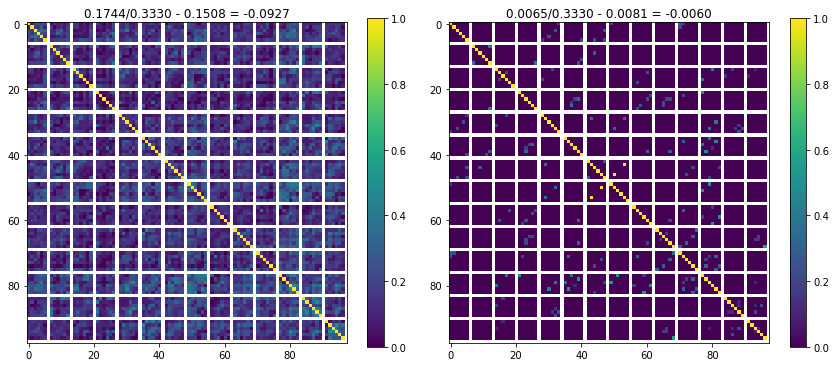

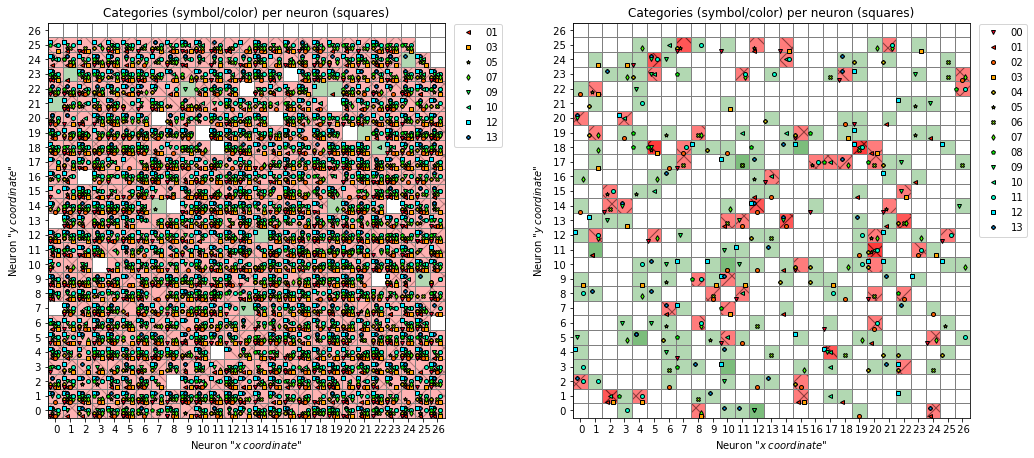



8: ../titan/data_gen0000000114_ind0000000011.npz
fitness
0.40878678691250114
avg_class_samp_distance
14.446138926709034
avg_activity_error
110.47619047619048
avg_sharing_class_error
139.01857142857142
avg_freq_error
21.74
{'A_minus': 6.6321294522351195,
 'A_plus': 1.5583072276151944,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.17938417290924513,
 'out_weight': 5.030028677467684,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -256.78862297805284
[98 98]
[98 98]
0.3689/0.3330 - 0.3378 = -0.2149
too low sim_fit


9: ../titan/data_gen0000000114_ind0000000010.npz
fitness
0.5999398874606257
avg_class_samp_distance
12.999074246142039
avg_activity_error
165.86904761904762
avg_sharing_class_error
159.3
avg_freq_error
35.27142857142857
{'A_minus': 7.232861984399213,
 'A_plus': 9.028081547359607,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.33061681004275545,
 'out_weight': 8.3068

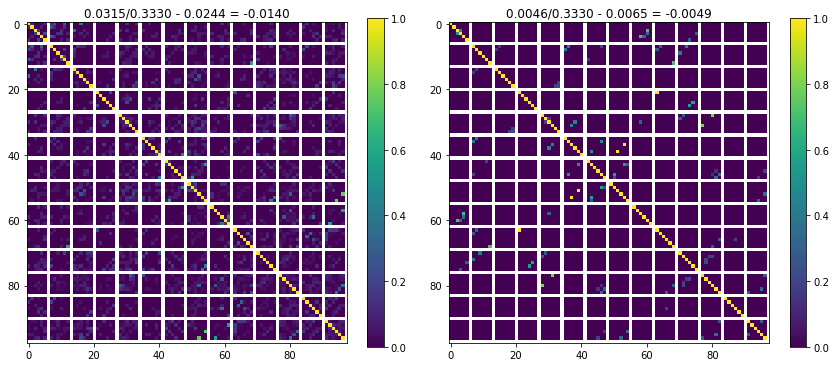

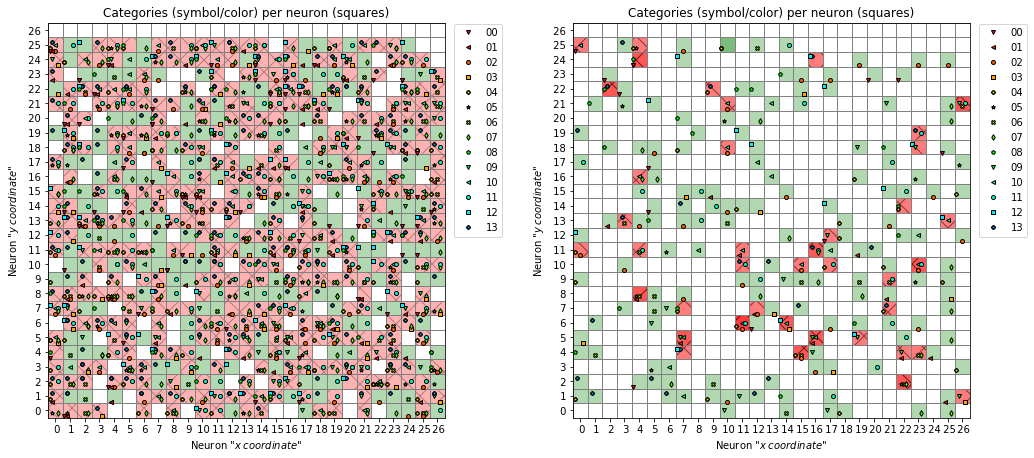



11: ../titan/data_gen0000000114_ind0000000008.npz
fitness
0.06161136550088231
avg_class_samp_distance
6.524490755225026
avg_activity_error
7.964285714285714
avg_sharing_class_error
5.491283676703645
avg_freq_error
0.01
{'A_minus': 7.789048470225662,
 'A_plus': 0.03767413882557836,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.051433013498955404,
 'out_weight': 7.451346606403997,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -6.941078635764334
[98 98]
[98 98]
0.0548/0.3330 - 0.0385 = -0.0203


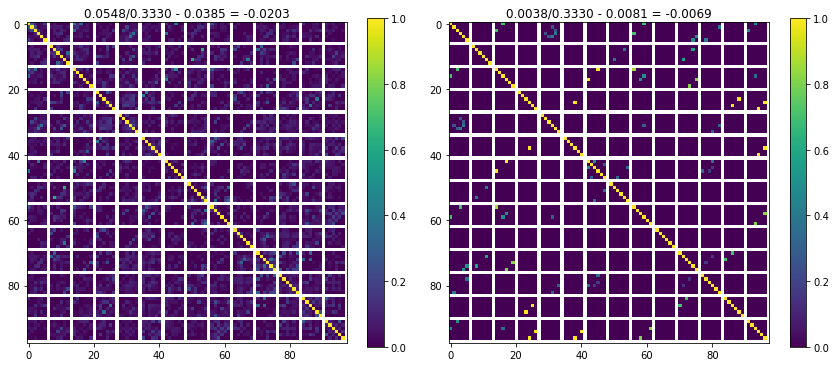

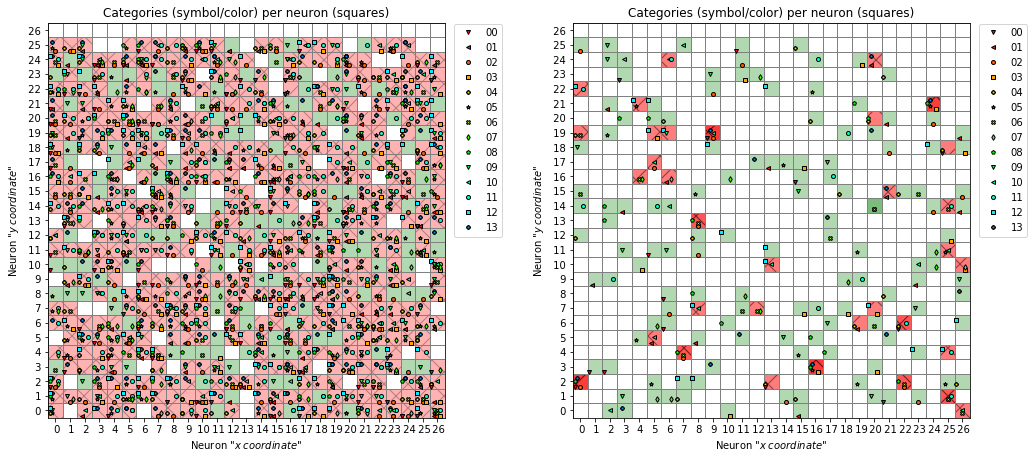



12: ../titan/data_gen0000000114_ind0000000007.npz
fitness
0.05986218106997051
avg_class_samp_distance
5.666932704745551
avg_activity_error
10.083333333333334
avg_sharing_class_error
3.1399317406143346
avg_freq_error
0.007142857142857143
{'A_minus': 10.0,
 'A_plus': 0.03767413882557836,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.02249588158516595,
 'out_weight': 7.451346606403997,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -7.563475226344974
[98 98]
[98 98]
0.0620/0.3330 - 0.0291 = -0.0085


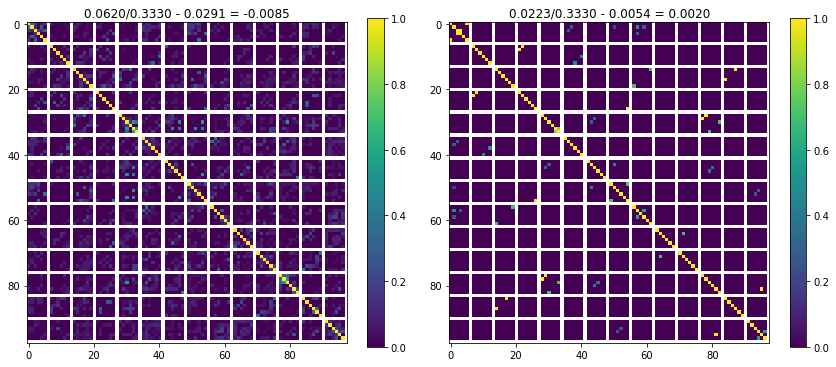

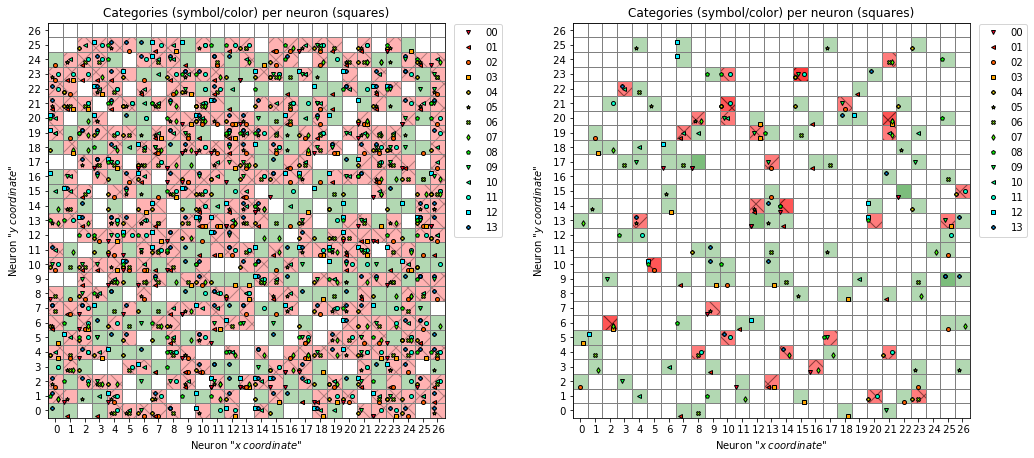



13: ../titan/data_gen0000000114_ind0000000006.npz
fitness
0.5140854116892501
avg_class_samp_distance
14.063552787615386
avg_activity_error
135.72619047619048
avg_sharing_class_error
151.77857142857144
avg_freq_error
27.927142857142858
{'A_minus': 7.789048470225662,
 'A_plus': 1.221413717534588,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.012051175258285888,
 'out_weight': 7.451346606403997,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -301.3683519742894
[98 98]
[98 98]
0.4495/0.3330 - 0.4256 = -0.2760
too low sim_fit


14: ../titan/data_gen0000000114_ind0000000005.npz
fitness
0.07103150007240402
avg_class_samp_distance
5.932171438378645
avg_activity_error
9.023809523809524
avg_sharing_class_error
4.359724612736661
avg_freq_error
0.014285714285714285
{'A_minus': 7.789048470225662,
 'A_plus': 0.03767413882557836,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.022495881585

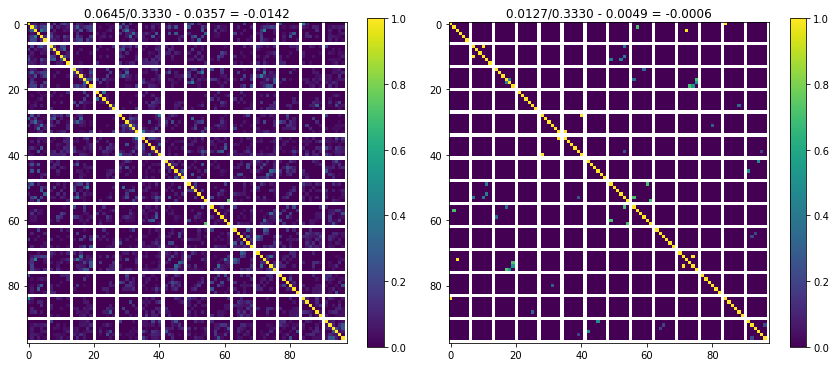

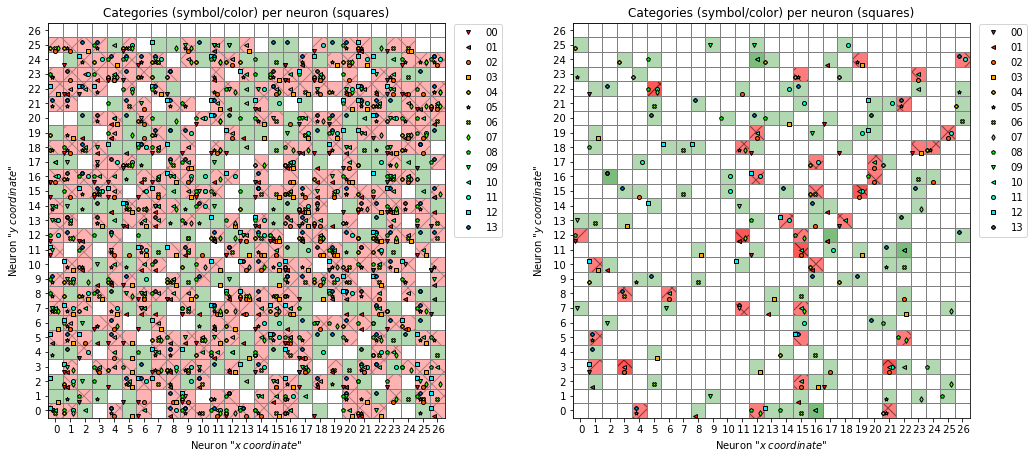



15: ../titan/data_gen0000000114_ind0000000004.npz
fitness
0.10186128874445698
avg_class_samp_distance
6.159384026087407
avg_activity_error
8.321428571428571
avg_sharing_class_error
4.33786078098472
avg_freq_error
0.01
{'A_minus': 7.789048470225662,
 'A_plus': 0.03767413882557836,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.02249588158516595,
 'out_weight': 7.451346606403997,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -6.5099053263258835
[98 98]
[98 98]
0.0754/0.3330 - 0.0362 = -0.0111


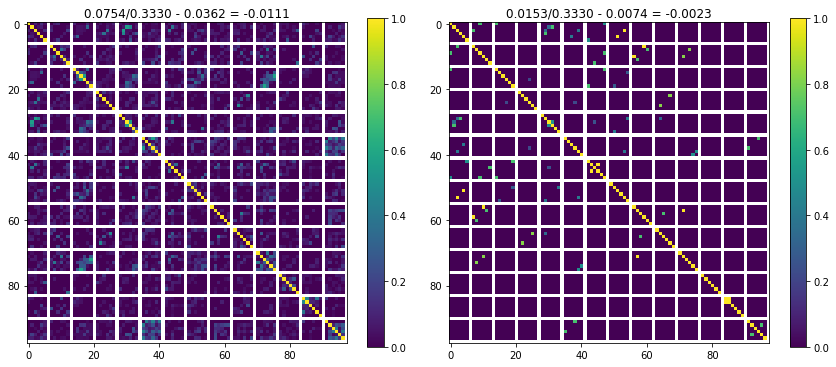

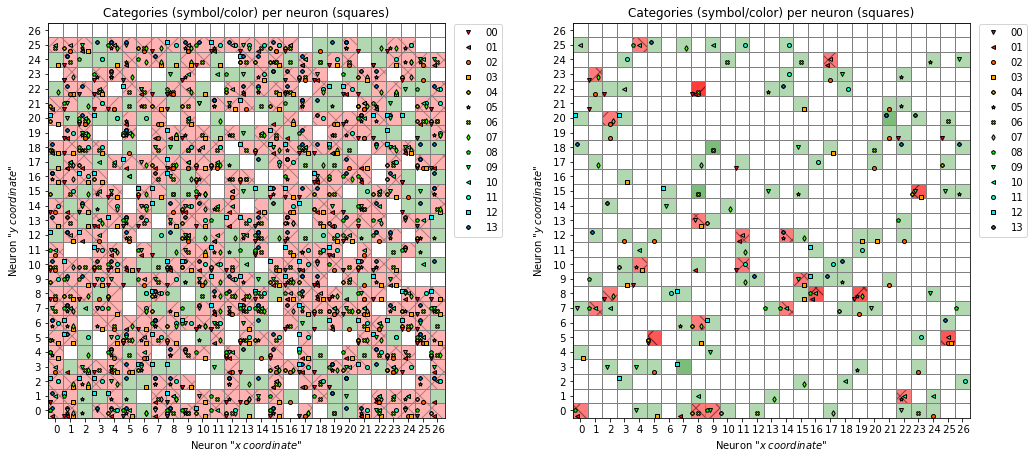



16: ../titan/data_gen0000000114_ind0000000003.npz
fitness
0.2883827908058031
avg_class_samp_distance
13.743767803401157
avg_activity_error
63.61904761904762
avg_sharing_class_error
93.35
avg_freq_error
10.40857142857143
{'A_minus': 5.630806248948575,
 'A_plus': 6.608772319079408,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.4709698522480994,
 'out_weight': 3.5951324216860354,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -153.63385124421788
[98 98]
[98 98]
0.2568/0.3330 - 0.2187 = -0.1331
too low sim_fit


17: ../titan/data_gen0000000114_ind0000000002.npz
fitness
0.47355945104342495
avg_class_samp_distance
13.961528201920716
avg_activity_error
140.39880952380952
avg_sharing_class_error
151.7357142857143
avg_freq_error
28.92142857142857
{'A_minus': 3.003213717048091,
 'A_plus': 7.773615003413048,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.3143068260003433,
 'out_weight

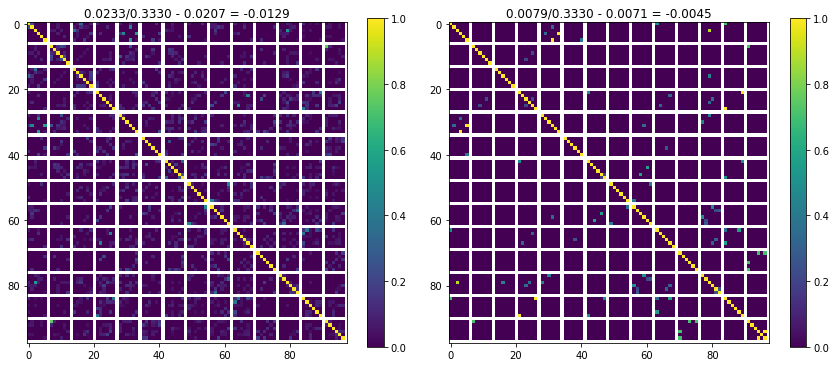

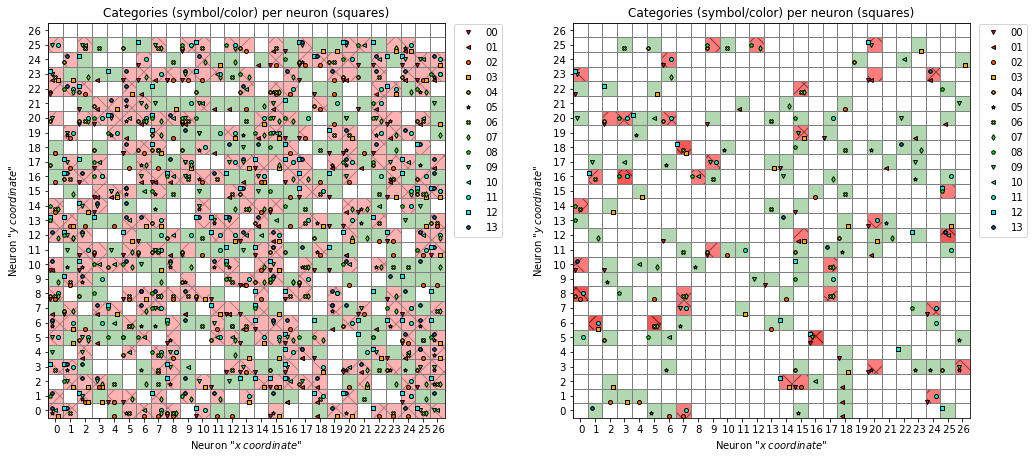



19: ../titan/data_gen0000000114_ind0000000000.npz
fitness
0.07392215809069014
avg_class_samp_distance
5.60056131553347
avg_activity_error
9.636904761904763
avg_sharing_class_error
3.2446043165467624
avg_freq_error
0.002857142857142857
{'A_minus': 7.789048470225662,
 'A_plus': 0.03767413882557836,
 'conn_dist': 1.0,
 'exp_prob': 4.0,
 'expand': 10.0,
 'mushroom_weight': 1.6,
 'out_prob': 0.02249588158516595,
 'out_weight': 7.451346606403997,
 'w_max_mult': 1.0,
 'w_min_mult': -0.001}
simulation fitness = -7.283804905775198
[98 98]
[98 98]
0.0561/0.3330 - 0.0290 = -0.0103


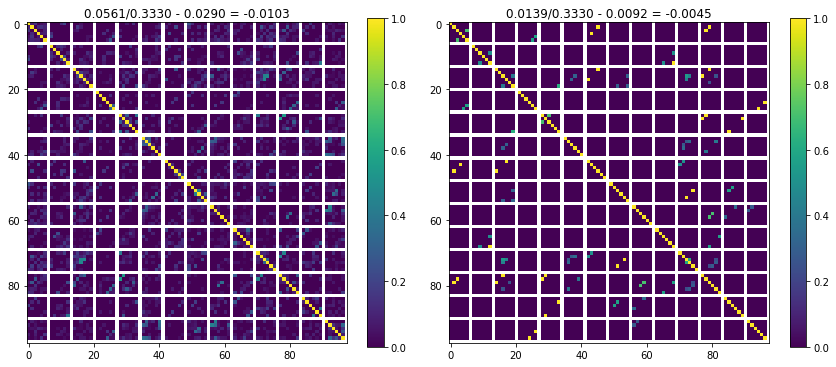

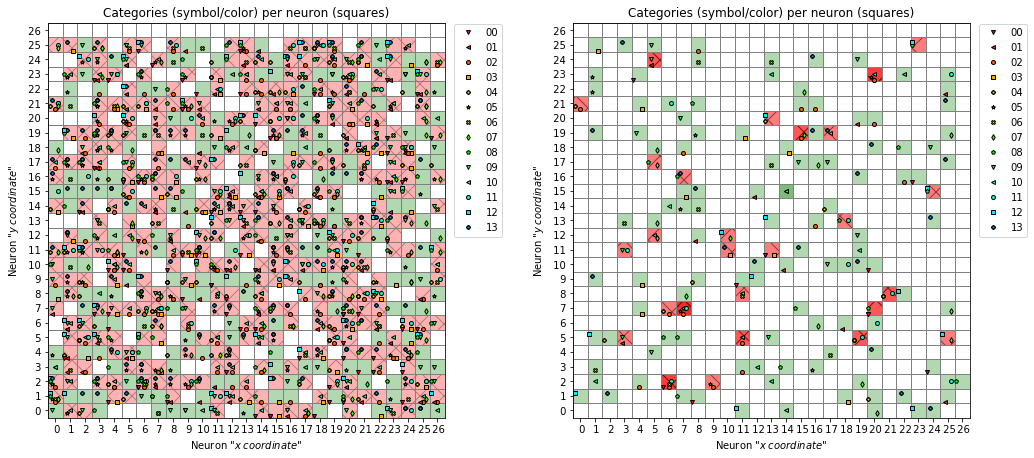

In [8]:
data_path = "../titan"
# data_path = "../titan_freq_punish_added"
# data_path = "../titan_shared_square"

gen = '00114'
search_pat = os.path.join(data_path, f'data_gen*{gen}_*npz')
file_names = sorted(glob.glob(search_pat), reverse=True)  # newest first
print(gen, search_pat, len(file_names))
colors = discrete_cmap(20, 'gnuplot')
cmap = matplotlib.cm.get_cmap('gnuplot')
_COLORS = [cmap(v) for v in np.arange(0., 1., 1. / 20.)]

max_d = 100.0
print(max_d)
data = {}
all_lengths = []
all_dists = []
max_vecs = []
max_d_s = -np.inf
max_labels = None
max_spikes = None
max_start_t = None
max_dt = None
max_npl = None
max_idx = None
fine_dists = []
target_activs = []
for fidx, f in enumerate(file_names[:]):
    print(f"\n\n{fidx}: {f}")
    with np.load(f, allow_pickle=True) as d:
        data = to_dict(d)
    
    for k in ['fitness', 'avg_class_samp_distance', 'avg_activity_error', 'avg_sharing_class_error', 'avg_freq_error']:
        print(k)
        print(data['analysis']['individual_per_class'][k])

    ind_ps = data['params']['ind']
    pprint(ind_ps)
    
    sim_ps = data['params']['sim']
    dt = sim_ps['sample_dt']
    n_class = sim_ps['num_classes']
    test_per_class = sim_ps['test_per_class']
    n_test = test_per_class * n_class
    
    out_binned = data['binned']['output']
    test_binned = out_binned[-n_test:]
    
    spikes = data['recs']['output'][0]['spikes']
    labels = data['input']['labels']
    out_spikes, out_labels = get_test_spikes_and_labels(data)

    start_t = get_test_label_idx(data) * dt
    end_t = start_t + n_test * dt


    n_out = len(spikes)
    out_per_class = n_out // n_class

    
#     print(len( test_binned ))
    fts = first_to_spike_activity_per_sample(test_binned)
    fts = [f[0] for f in fts]
#     print(test_labels)
#     pprint(fts)
#     break
    
    sim_fit = data['fitness']
    print(f'simulation fitness = {sim_fit}')

#     plt.figure(figsize=(10, 10))
#     plot_first_to_spike(labels, fts, n_out,  ms=6, 
#             markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1)
    
    aps = activity_per_sample(out_labels, out_spikes, start_t, dt)
#     pprint(aps)
    vs = act_per_samp_to_dict(aps, out_labels, n_out)
#     print(vs)
    
    # print(neurons_per_label)
    # corrs, intra, inter
    correlations, intra_d, inter_d = cc(vs)
    correlations = expand_cross(correlations, n_class)
    
    fvs = act_per_samp_to_dict(fts, out_labels, n_out)
    fcorrelations, fintra_d, finter_d = cc(fvs)
    fcorrelations = expand_cross(fcorrelations, n_class)
    
    w = 0.333
    
    
#     print(np.mean(intra_d), np.mean(inter_d))
    minter, mintra = np.mean(inter_d), np.mean(intra_d)
    fminter, fmintra = np.mean(finter_d), np.mean(fintra_d)

    print("{:.4f}/{:.4f} - {:.4f} = {:.4f}".format(mintra, w, minter, mintra*w - minter))

    if sim_fit < -100.:
        print('too low sim_fit')
        continue
    
    plt.figure(figsize=(12, 5))
    ax = plt.subplot(1, 2, 1)
    im = plt.imshow(correlations)
    ax.set_title("{:.4f}/{:.4f} - {:.4f} = {:.4f}".format(mintra, w, minter, mintra*w - minter))
    plt.colorbar(im)

    ax = plt.subplot(1, 2, 2)
    im = plt.imshow(fcorrelations)
    ax.set_title("{:.4f}/{:.4f} - {:.4f} = {:.4f}".format(fmintra, w, fminter, fmintra*w - fminter))
    plt.colorbar(im)
    plt.tight_layout()

    
    plt.figure(figsize=(15, 7))
    ax = plt.subplot(1, 2, 1)
    un = plot_test_map_single(
            out_labels, out_spikes, start_t, dt, ms=4, 
            markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1)
    
    ax = plt.subplot(1, 2, 2)

    plot_first_to_spike(
            out_labels, fts, n_out,  ms=4, 
            markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1)

    plt.tight_layout(pad=3.)
    plt.show()

#     break
#     continue

In [53]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def to_dataset(vec_dict, split=0.75):
    n_class = len(vec_dict)
    n_samp = len(vec_dict[list(vec_dict.keys())[0]])
    n_train = int(n_samp * split)
    n_test = n_samp - n_train
    x_l = []
    y_l = []
    x_t = []
    y_t = []
    for c in vec_dict:
        train_ids = np.random.choice(n_samp, n_train, replace=False)
        for i in train_ids:
            x_l.append(vec_dict[c][i])
            y_l.append(c)
        
        if n_test > 0:
            test_ids = set(range(n_samp)) - set(train_ids)

            for i in test_ids:
                x_t.append(vec_dict[c][i])
                y_t.append(c)
    
    x_l = np.asarray(x_l)
    y_l = np.asarray(y_l)
    
#     print(x_l.shape, y_l.shape)
    i = np.arange(len(x_l))
    np.random.shuffle(i)

    x_l[:] = x_l[i, :]
    y_l[:] = y_l[i]
    
    if n_test > 0:

        x_t = np.asarray(x_t)
        y_t = np.asarray(y_t)

        i = np.arange(len(x_t))
        np.random.shuffle(i)
        x_t[:] = x_t[i, :]
        y_t[:] = y_t[i]
    else:
        x_t = x_l
        y_t = y_l
    
    return x_l, y_l, x_t, y_t

f = file_names[16]
with np.load(f, allow_pickle=True) as d:
    data = to_dict(d)
#     pprint(data['params'])#['ind'])
#     for k in ['fitness', 'avg_class_samp_distance', 'avg_activity_error', 'avg_sharing_class_error', 'avg_freq_error']:
#         print("{} = {}".format(k, data['analysis']['individual_per_class'][k]))
    
    sim_ps = data['params']['sim']
    dt = sim_ps['sample_dt']
    n_class = sim_ps['num_classes']
    test_per_class = sim_ps['test_per_class']
    n_test = test_per_class * n_class

    out_binned = data['binned']['output']
    test_binned = out_binned[-n_test:]
    
#     spikes = data['recs']['output'][0]['spikes']
    labels = data['input']['labels']
#     out_spikes, out_labels = get_test_spikes_and_labels(data)
    test_labels = labels[-n_test:]
    
    fts = first_to_spike_activity_per_sample(test_binned)
    fts = [f[0] for f in fts]
    fvs = act_per_samp_to_dict(fts, test_labels, n_out)

    X, y, xt, yt = to_dataset(fvs, split=1.)
    
#     tsx = TSNE(n_components=2).fit_transform(X)
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.scatter(tsx[:, 0], tsx[:, 1], c=y)

#     pca = PCA(n_components=3)
#     pca = SparsePCA(n_components=2, random_state=0)
#     pca_result = pca.fit_transform(X)
#     fig = plt.figure(figsize=(16,10))
#     ax = fig.add_subplot(111)#, projection='3d')
#     ax.scatter(
#         x=pca_result[:, 0], 
#         y=pca_result[:, 1], 
# #         zs=pca_result[:, 2], 
#         c=y, 
#         cmap='tab10'
#     )
#     ax.set_xlabel('pca-one')
#     ax.set_ylabel('pca-two')
#     ax.set_zlabel('pca-three')
#     plt.show()
    
    
    
#     print(X.shape, y.shape)
#     print(xt.shape, yt.shape)
    
    clf = LinearSVC(random_state=0, tol=1e-5)
    clf.fit(X, y)
    
    correct = 0.
    for ii, xx in enumerate(xt):
        yy = clf.predict(xx.reshape(1, -1))
        c = False
        if yy == yt[ii]:
            c = True
            correct += 1.
    
        print(ii, yt[ii], yy, c)

    print("{}/{} = {:6.2f}%".format(correct, len(xt), 100.*correct / len(xt)))

0 9 [9] True
1 7 [7] True
2 11 [11] True
3 1 [1] True
4 4 [4] True
5 5 [5] True
6 13 [13] True
7 6 [6] True
8 8 [8] True
9 13 [13] True
10 0 [0] True
11 3 [3] True
12 7 [7] True
13 12 [12] True
14 12 [12] True
15 13 [13] True
16 9 [9] True
17 3 [3] True
18 5 [5] True
19 2 [2] True
20 2 [2] True
21 1 [1] True
22 2 [2] True
23 6 [6] True
24 7 [7] True
25 2 [2] True
26 0 [0] True
27 8 [8] True
28 5 [5] True
29 6 [6] True
30 10 [10] True
31 10 [10] True
32 3 [3] True
33 12 [12] True
34 8 [8] True
35 6 [6] True
36 4 [4] True
37 0 [0] True
38 13 [13] True
39 12 [12] True
40 4 [4] True
41 7 [7] True
42 9 [9] True
43 5 [5] True
44 4 [4] True
45 1 [1] True
46 11 [11] True
47 3 [3] True
48 11 [11] True
49 0 [0] True
50 11 [11] True
51 10 [10] True
52 8 [8] True
53 1 [1] True
54 10 [10] True
55 9 [9] True
56.0/56 = 100.00%


In [ ]:
data_path = "../titan"
# data_path = "../titan_freq_punish_added"
# data_path = "../titan_shared_square"

gen = '00202'
search_pat = os.path.join(data_path, f'data_gen*{gen}_*npz')
file_names = sorted(glob.glob(search_pat), reverse=True)  # newest first
print(gen, search_pat, len(file_names))
colors = discrete_cmap(20, 'gnuplot')
cmap = matplotlib.cm.get_cmap('gnuplot')
_COLORS = [cmap(v) for v in np.arange(0., 1., 1. / 20.)]

max_d = 100.0
print(max_d)
data = {}
all_lengths = []
all_dists = []
max_vecs = []
max_d_s = -np.inf
max_labels = None
max_spikes = None
max_start_t = None
max_dt = None
max_npl = None
max_idx = None
fine_dists = []
target_activs = []
for fidx, f in enumerate(file_names[:]):
    print(f"\n\n{fidx}: {f}")
    with np.load(f, allow_pickle=True) as d:
        data = to_dict(d)
    
    
    sim_ps = data['params']['sim']
    dt = sim_ps['sample_dt']
    n_class = sim_ps['num_classes']
    test_per_class = sim_ps['test_per_class']
    n_test = test_per_class * n_class
    
    out_binned = data['binned']['output']
    test_binned = out_binned[-n_test:]
    
    spikes = data['recs']['output'][0]['spikes']
    labels = data['input']['labels']
    test_labels = labels[-n_test:]
    out_spikes, out_labels = get_test_spikes_and_labels(data)


    n_out = len(spikes)
    out_per_class = n_out // n_class

    
#     print(len( test_binned ))
    fts = first_to_spike_activity_per_sample(test_binned)
    fts = [f[0] for f in fts]
#     print(test_labels)
#     print(fts)

    sim_fit = data['fitness']
    print(f'simulation fitness = {sim_fit}')

#     plt.figure(figsize=(10, 10))
#     plot_first_to_spike(labels, fts, n_out,  ms=6, 
#             markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1)
    
    aps = activity_per_sample(out_labels, out_spikes, start_t, dt)
    vs = act_per_samp_to_dict(aps, out_labels, n_out)
    # print(vs)
    # print(neurons_per_label)
    # corrs, intra, inter
    correlations, intra_d, inter_d = cc(vs)

    print(np.mean(intra_d), np.mean(inter_d))
    minter, mintra = np.mean(inter_d), np.mean(intra_d)
    
    plt.figure()
    ax = plt.subplot(1, 1, 1)
    im = plt.imshow(correlations)
    ax.set_title("{:.4f}/2 - {:.4f} = {:.4f}".format(mintra, minter, mintra*0.5 - minter))
    plt.colorbar(im)

    
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 2, 1)
    un = plot_test_map_single(out_labels,
                         out_spikes,
                         start_t,
                         dt,
                         6,
                         colors=_COLORS)
    
    ax = plt.subplot(1, 2, 2)
    plot_first_to_spike(labels, fts, n_out,  ms=6, 
            markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1)


    plt.show()

#     break
    continue

    
    corr = expand_cross(data['correlations']['output'], n_class)

    analysis = data['analysis']
    avg_sharing_class_error = analysis['aggregate_per_class'][
        'avg_sharing_class_error']
    #     avg_freq_error = analysis['aggregate_per_class']['avg_freq_error']
    avg_class_sample_distance = analysis['individual_per_class'][
        'avg_class_samp_distance']
    avg_activity_error = analysis['individual_per_class']['avg_activity_error']
    sqrt_avg_activity_error = np.sqrt(avg_activity_error)


    print(f'avg_sharing_class_error = {avg_sharing_class_error:0.4f}')
    print(f'avg_class_sample_distance = {avg_class_sample_distance:0.4f}')
    print(
        f'avg_activity_error = {avg_activity_error:0.4f} sqrt = {sqrt_avg_activity_error:0.4f}'
    )
    #     print(f'avg_freq_error = {avg_freq_error:0.4f}')
    #     comp_fit = avg_class_sample_distance - avg_activity_error - avg_sharing_class_error - avg_freq_error
    comp_fit = 0
    print(f'comp fitness = {comp_fit:0.4f}')

    start_t = get_test_label_idx(data) * dt
    end_t = start_t + n_test * dt

    #     start_t = get_test_label_idx(data) * dt
    out_spikes, out_labels = get_test_spikes_and_labels(data)
    end_t = start_t + len(out_labels) * dt
    n_out = len(out_spikes)

    aps = activity_per_sample(out_labels, out_spikes, start_t, dt)
    vs = act_per_samp_to_dict(aps, out_labels, n_out)
    # print(vs)
    # print(neurons_per_label)
    # corrs, intra, inter
    correlations, intra_d, inter_d = cc(vs)
    
    total_test_rate = np.sum([len(ts) for ts in out_spikes])
    mean_test_rate = total_test_rate  #/ float(n_out)
    #     print(f"total_test_rate = {total_test_rate} : average = {mean_test_rate}")

    high_thresh = sim_ps['num_classes'] * sim_ps['test_per_class'] * 0.5
    high, rates = high_rate(start_t, out_spikes, n_class)
    n_high = len(high)
    #     print(f'high rate (> {high_thresh}) neurons {high} \n rate {rates}')

    labels_per_neuron = get_labels_per_neuron(out_labels, out_spikes, start_t,
                                              dt)
    num_labels_for_neurons = [
        len(np.unique(labels_per_neuron[k])) for k in labels_per_neuron
    ]
    hi_num_labels_for_neurons = [n for n in num_labels_for_neurons if n > 1]
    #     avg_num_labels_per_neuron = np.mean(hi_num_labels_for_neurons)
    avg_num_labels_per_neuron = len(hi_num_labels_for_neurons)
    #     avg_num_labels_per_neuron = n_class * n_out if np.isnan(avg_num_labels_per_neuron) else avg_num_labels_per_neuron

    neurons_per_label = get_neurons_per_label(out_labels, out_spikes, start_t,
                                              dt)
    all_lengths += [
        len(np.unique(neurons_per_label[k])) for k in neurons_per_label
    ]
    dists = get_distances(neurons_per_label)
    unique_d = []
    for i in range(dists.shape[0])[:-1]:
        for j in range(i + 1, dists.shape[0]):
            unique_d.append(dists[i, j])

    all_dists += unique_d

    max_unique = np.max(unique_d)
    #     print(f'maximum manhattan {max_unique}')
    if np.sum(unique_d) > 0 and sim_fit > 0:
        all_dists += unique_d

    vectors = [np.zeros(n_out) for _ in neurons_per_label]
    for l in sorted(neurons_per_label.keys()):
        vectors[l][neurons_per_label[l]] = 1

    max_l = np.max([np.sum(v) for v in vectors])
    #     print(f'maximum vector length {max_l}')

    aps = activity_per_sample(out_labels, out_spikes, start_t, dt)
    sorted_aps = sort_activity_per_sample(out_labels, aps)
    n_aps = [len(v) for v in aps]
    n_tests = len(n_aps)
    n_zero_aps = np.sum([1 for s in n_aps if s == 0])

    above_thr = vectors_above_threshold(vectors, int(n_out * 0.3))
    zeros = [i for i, v in enumerate(vectors) if np.sum(v) <= 0.1]
    pabove = len(above_thr)  # / float(n_class)
    pzero_accum = 0  #len(zeros)# / float(n_class)
    pzero_ind = n_zero_aps  #/float(n_tests)
    #     print(f"vectors above threshold = {above_thr}")
    #     print(f"zero sum vector ids = {zeros}")
    #     print(f"num active per test sample = {n_aps}\n\tnum of zero active = {n_zero_aps}")

    #     punish = 1.0 * (pabove + pzero_accum + pzero_ind + avg_num_labels_per_neuron + n_high * mean_test_rate)
    #     print("{punish} = ({pabove} + {pzero_accum} + {pzero_ind} + {avg_n_labels} + {n_high * mean_test_rate})")
    #     print(f"{punish} = ({pabove} + {pzero_accum} + {pzero_ind} + {avg_num_labels_per_neuron} + {n_high * mean_test_rate})")
    punish = 1.0 * (pabove + pzero_accum + pzero_ind +
                    avg_num_labels_per_neuron + mean_test_rate)
    #     print("{punish} = ({pabove} + {pzero_accum} + {pzero_ind} + {avg_n_labels} + {mean_test_rate})")
    #     print(f"{punish} = ({pabove} + {pzero_accum} + {pzero_ind} + {avg_num_labels_per_neuron} + {mean_test_rate})")
    #     avg = np.mean(np.clip(unique_d, 0., 50.0))
    avg = np.sum(unique_d)
    #     avg = np.mean(unique_d)
    cont_avg = np.copy(avg)
    #     vmax = np.sqrt(len(out_spikes))
    #     vmax = len(out_spikes) / 2.0
    #     colors = discrete_cmap(int(np.ceil(vmax)), 'gist_rainbow')
    #     try:
    #         colors = discrete_cmap(int(np.ceil(max_d)), 'gist_rainbow')
    #     except:
    #         colors = 'gist_rainbow'
    #     max_d = max_unique
    #     max_d = 50
    #     avg = np.clip(avg/max_d, 0., 1.0) * 0.3
    act_per_samp = activity_per_sample(out_labels, out_spikes, start_t, dt)

    punish_activity = error_sample_target_activity(
        target=out_per_class, activity_per_sample=act_per_samp)
    punish_activity /= float(n_out)
    reward_distance = mean_per_sample_class_distance(act_per_samp, out_labels,
                                                     n_out)
    #     print(f'punish_activity = {punish_activity}')
    #     print(f'reward_distance = {reward_distance}')
    target_activs.append(punish_activity)
    fine_dists.append(reward_distance)

    local_max = reward_distance - punish_activity
    #     local_max = avg / punish
    local_max = sim_fit
    #     local_max = comp_fit
    #     local_max = np.max(dists)
    if local_max > max_d_s:
        max_d_s = local_max
        max_vecs = neurons_per_label
        max_labels = out_labels
        max_spikes = out_spikes
        max_start_t = start_t
        max_npl = neurons_per_label
        max_dt = dt
        max_idx = fidx

#     continue

        
#     if sim_fit <= -196. or sim_fit < -1000.:
#         print(f"zero avg {avg:8.4f} index {fidx}")
#         continue

    if sim_fit < -5000.:
        print(f"zero avg {avg:8.4f} index {fidx}")
        continue

    fig = plt.figure(figsize=(18, 5))
    widths = [1, 3]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
    plt.suptitle(f)
    ax = fig.add_subplot(spec[0, 0])
    ax.set_title(f"{avg:8.4f} - {punish:8.4f} = {local_max:8.4f} index {fidx}")
    im = plt.imshow(dists / max_d, interpolation='nearest',
                    cmap=colors)  #, vmax=1.0)
    plt.colorbar(im)
    #     fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(spec[0, 1])
    gray = False
    for t in np.arange(start_t, end_t, dt):
        idx = int((t - start_t) // dt)
        clr = 'gray' if gray else 'white'
        gray = not gray
        if empty(t, dt, out_spikes):
            clr = 'red'

        plt.axvspan(t, t + dt, color=clr, alpha=0.3)
        lbl = out_labels[idx]
        plt.text(t, n_out, f"{lbl}")

    for idx, ts in enumerate(out_spikes):
        plt.plot(ts,
                 np.ones_like(ts) * idx,
                 '.b',
                 markersize=5,
                 markeredgewidth=0)
    ax.set_xlim(start_t - 10, end_t + 10)
    ax.set_ylim(-10, n_out + 10)
    #     plt.figure()
    #     plot_test_map(out_labels, out_spikes, start_t, dt, 10)

#     plt.figure(figsize=(8, 6))
#     im = plt.imshow(corr)
#     plt.colorbar(im)
    
    print(np.mean(intra_d), np.mean(inter_d))
    minter, mintra = np.mean(inter_d), np.mean(intra_d)
    
    plt.figure()
    ax = plt.subplot(1, 1, 1)
    im = plt.imshow(correlations)
    ax.set_title("{:.4f}/2 - {:.4f} = {:.4f}".format(mintra, minter, mintra*0.5 - minter))
    plt.colorbar(im)

    
    
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(1, 1, 1)
    for idx in range(len(sorted_aps)):
        cls = idx // test_per_class
        ttt = dt * idx
        if (idx % test_per_class) == 0:
            plt.axvline(ttt - dt // 3, color='gray', linestyle='--')
            plt.text(ttt, n_out, f'{cls}')

        for y in sorted_aps[idx]:
            plt.plot(ttt, y, '.b')

    ax.set_ylim(-10, n_out + 10)

    if len(zeros) < n_class:
        plt.figure(figsize=(10, 10))
        un = plot_test_map_single(out_labels,
                             out_spikes,
                             start_t,
                             dt,
                             6,
                             colors=_COLORS)
#         vs = []
#         for c in range(n_class):
            
    plt.show()

#     print(f)
#     print("distance sum = {:8.4f}".format(dists.sum()))

print()

In [5]:
print(max_idx)
# 47
max_idx = 10
# np.sqrt(19100)

None


In [6]:
# fname = file_names[max_idx]
# # fname = file_names[14]
# with np.load(fname, allow_pickle=True) as d:
#     data = to_dict( d )
    
# print(data.keys())
# print(data['analysis']['individual_per_class'].keys())
# for k in ['fitness', 'avg_class_samp_distance', 'avg_activity_error']:
#     print(k)
#     print(data['analysis']['individual_per_class'][k])

dict_keys(['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitness0', 'fitness1', 'fitness'])
{'A_minus': 10.0,
 'A_plus': 1.9431587941859287,
 'conn_dist': 6.0,
 'exp_prob': 4.0,
 'expand': 20.0,
 'mushroom_weight': 1.0,
 'out_prob': 0.18072134803058432,
 'out_weight': 3.871986040041992,
 'w_max_mult': 1.0,
 'w_min_mult': 0.0}
84 56
[98 98]
[98 98]


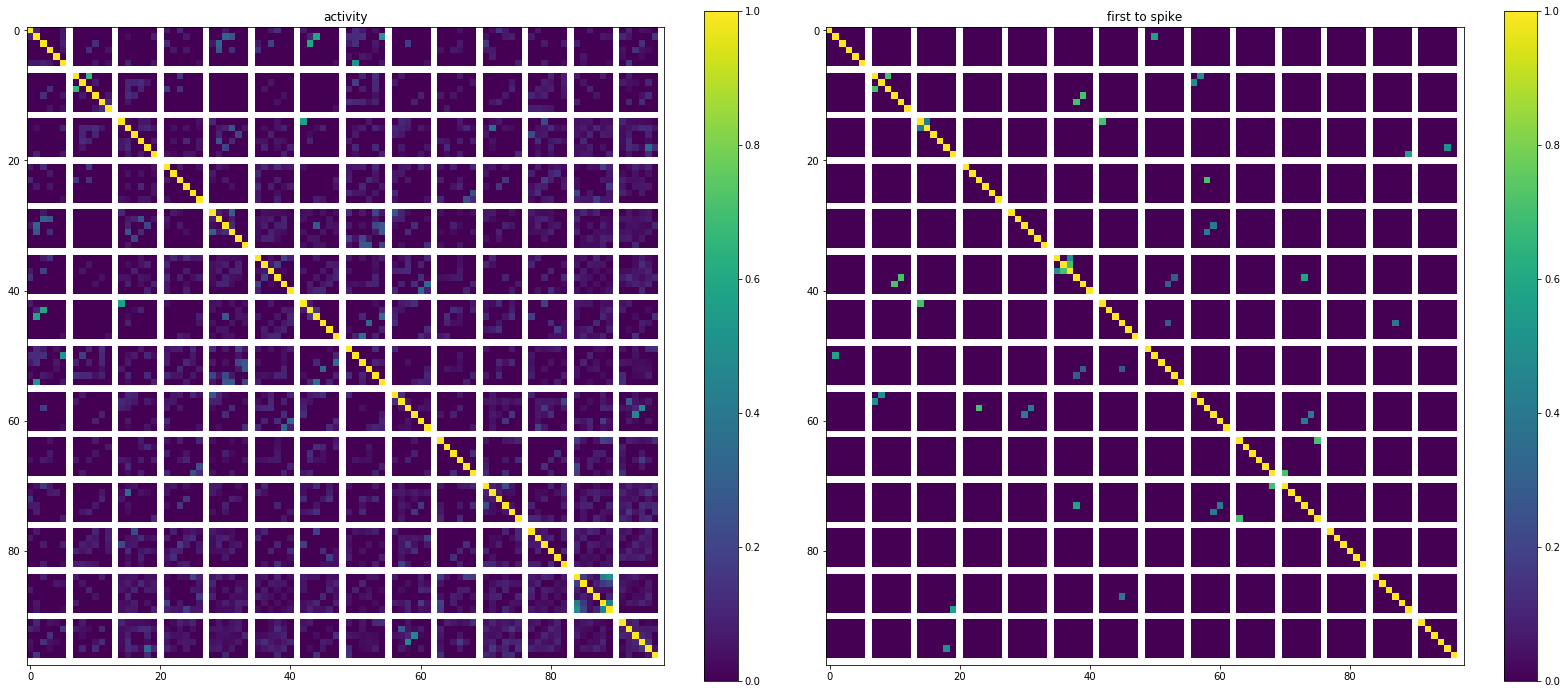

avg_freq_error = 3.6142857142857143


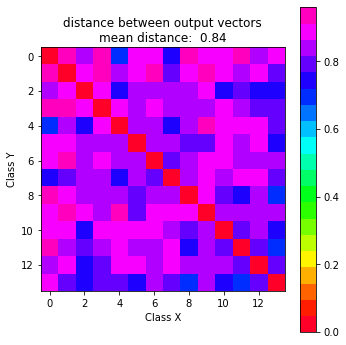

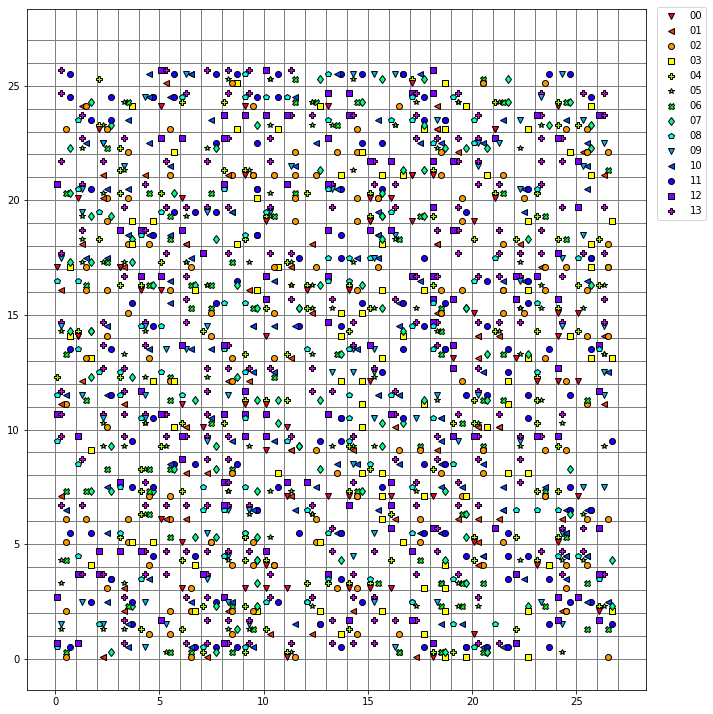

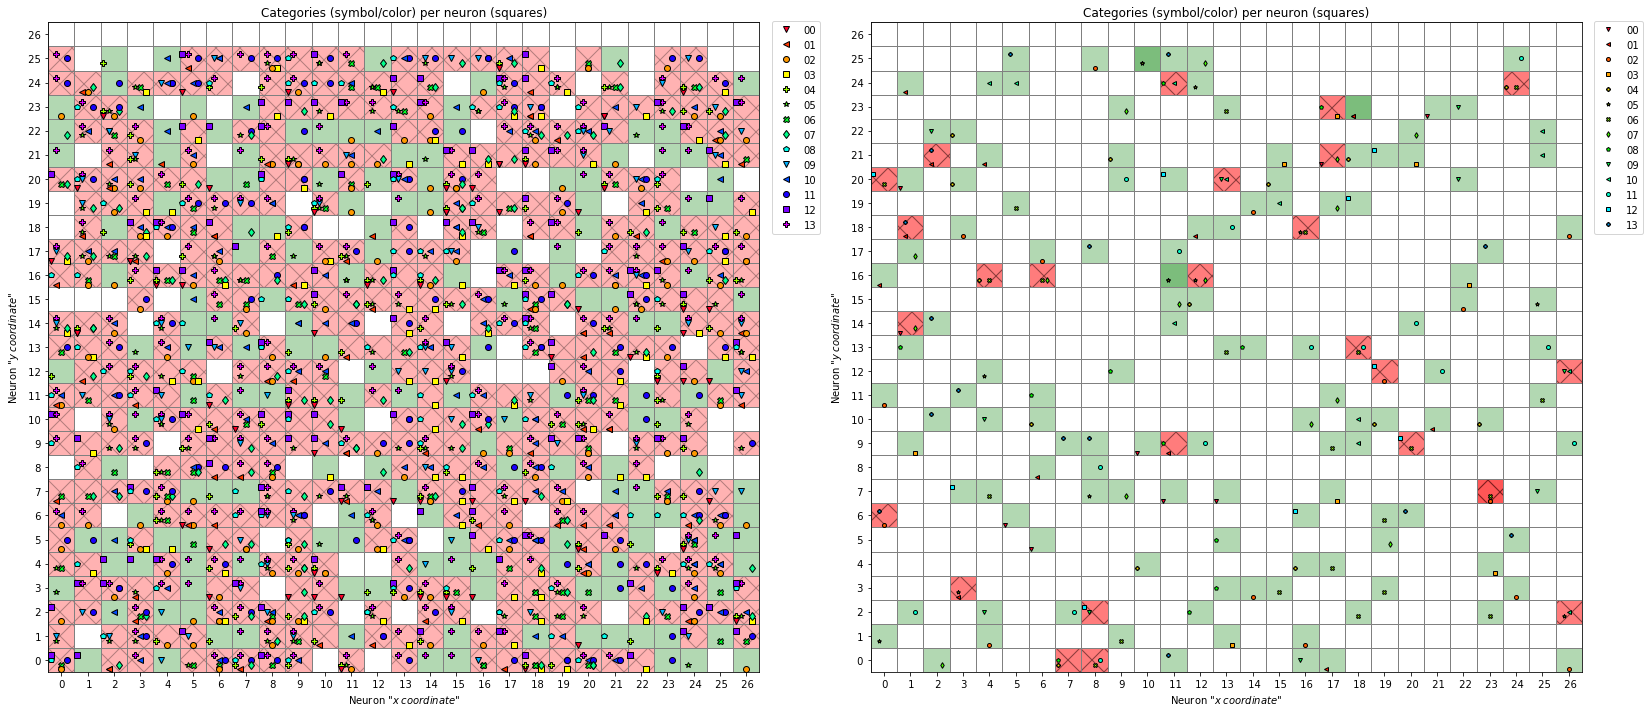

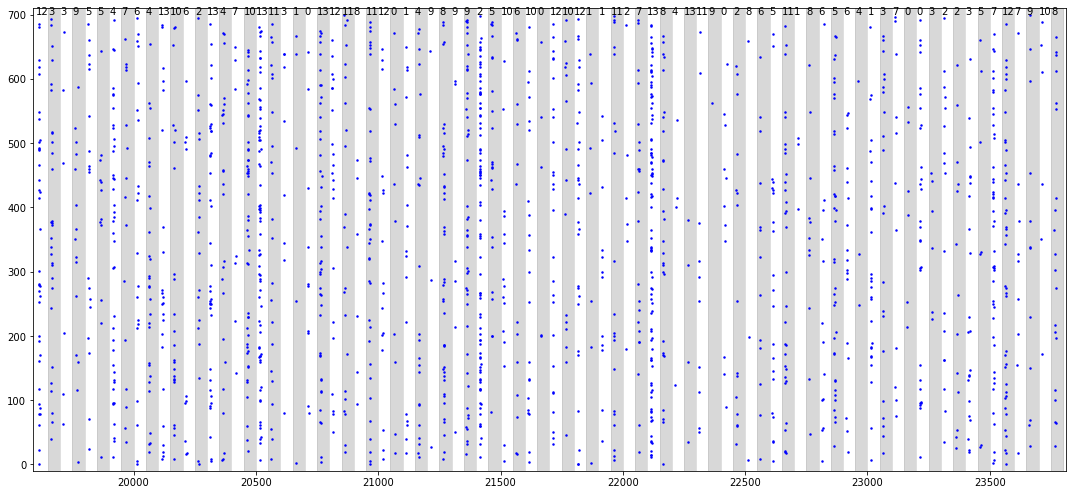

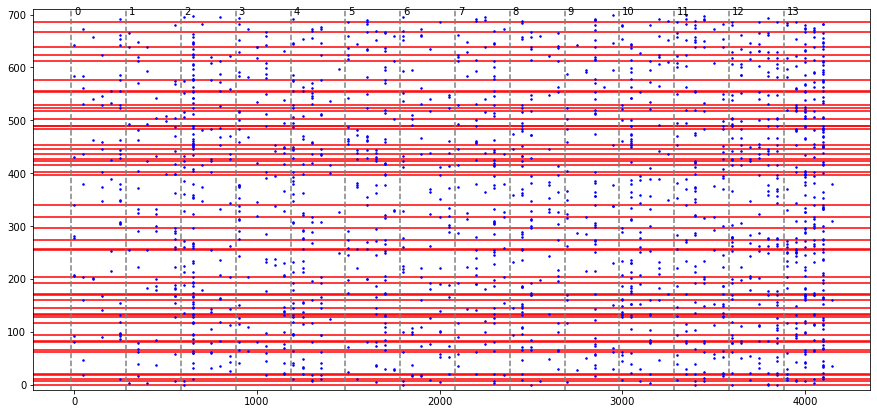

In [7]:

fname = file_names[max_idx]
# fname = file_names[14]
with np.load(fname, allow_pickle=True) as d:
    data = to_dict( d )
    
print(data.keys())

ind_ps = data['params']['ind']
pprint(ind_ps)
sim_ps = data['params']['sim']
# pprint(sim_ps)
# print(data.keys())
dt = sim_ps['sample_dt']
start_t = get_test_label_idx(data) * dt
end_t = start_t + len(out_labels) * dt
test_per_class = sim_ps['test_per_class']
sim_fit = data['fitness']
# print(f'simulation fitness = {sim_fit}')
n_out = sim_ps['output_size']
n_class = sim_ps['num_classes']
test_per_class = sim_ps['test_per_class']
n_test = test_per_class * n_class

out_binned = data['binned']['output']
test_binned = out_binned[-n_test:]


out_spikes, out_labels = get_test_spikes_and_labels(data)
neurons_per_label = get_neurons_per_label(
                        out_labels, out_spikes, start_t, dt)

fts = first_to_spike_activity_per_sample(test_binned)
fts = [f[0] for f in fts]

aps = activity_per_sample(out_labels, out_spikes, start_t, dt)
print( len(aps), 14*4 )
vs = act_per_samp_to_dict(aps, out_labels, n_out)
# print(vs)
# print(neurons_per_label)
correlations, intra_d, inter_d = cc(vs)
correlations = expand_cross(correlations, n_class)

fvs = act_per_samp_to_dict(fts, out_labels, n_out)
fcorrelations, fintra_d, finter_d = cc(fvs)
fcorrelations = expand_cross(fcorrelations, n_class)

fig = plt.figure(figsize=(23, 10))
ax = plt.subplot(1, 2, 1)
ax.set_title('activity')
im = plt.imshow(correlations)
plt.colorbar(im)

ax = plt.subplot(1, 2, 2)
ax.set_title('first to spike')
im = plt.imshow(fcorrelations)
plt.colorbar(im)

plt.tight_layout(pad=2.)
plt.savefig('correlations__{}.png'.format(gen), dpi=150)
plt.show()

n_class = sim_ps['num_classes']

# high_thresh = sim_ps['num_classes'] * sim_ps['test_per_class'] #* 0.5
high_thresh = sim_ps['test_per_class'] #* 0.5
# high = high_rate(start_t, out_spikes, n_class)
# print(f'high (> {high_thresh}) rate neurons {high}')
ids, rates = high_rate(start_t, out_spikes, high_thresh)

avg_freq_error = mean_target_frequency_error(
                    high_thresh, out_spikes, power=1)
print(f'avg_freq_error = {avg_freq_error}')

aps = activity_per_sample(out_labels, out_spikes, start_t, dt)
sorted_aps = sort_activity_per_sample(out_labels, aps)

max_d = 160.0
dists = get_distances(neurons_per_label) #/ max_d
colors = discrete_cmap(20, 'gist_rainbow')
# colors = discrete_cmap(20, 'gnuplot')
unique_d = []
for i in range(dists.shape[0])[:-1]:
    for j in range(i+1, dists.shape[0]):
        unique_d.append(dists[i, j])

cmap = matplotlib.cm.get_cmap('gist_rainbow')
_COLORS = [cmap(v) for v in np.arange(0., 1., 1./14.)]

plt.figure(figsize=(5,5))
# plt.suptitle('')
ax = plt.subplot(1, 1, 1)
avg_d = np.mean(unique_d)
ax.set_title(f'distance between output vectors\nmean distance: {avg_d:5.2f}')
im = plt.imshow(dists, interpolation='nearest', cmap=colors)#, vmax=vmax)
plt.colorbar(im)
ax.set_xlabel('Class X')
ax.set_ylabel('Class Y')
plt.tight_layout()
plt.savefig(f'distances_{gen}.png', dpi=150)

plt.figure(figsize=(10, 10))
plot_test_map(out_labels, out_spikes, start_t, dt, 6, colors=_COLORS)
plt.tight_layout()
plt.savefig(f'map_{gen}.pdf')

plt.figure(figsize=(23, 10))
ax = plt.subplot(1, 2, 1)
ax.set_title('activity')
plot_test_map_single(out_labels, out_spikes, start_t, dt, 6, colors=_COLORS)

ax = plt.subplot(1, 2, 2)
ax.set_title('first to spike')
plot_first_to_spike(
        out_labels, fts, n_out,  ms=4, 
        markers=DEF_MARKERS, colors=DEF_COLORS, edgewidth=1)

plt.tight_layout()
plt.savefig(f'map_single_{gen}.png', dpi=150)



plt.figure(figsize=(15, 7))
ax = plt.subplot(1, 1, 1)
gray = False
for t in np.arange(start_t, end_t, dt):
    idx = int((t-start_t) // dt)
    clr = 'gray' if gray else 'white'
    gray = not gray
    if empty(t, dt, out_spikes):
        clr = 'red'
    plt.axvspan(t, t+dt, color=clr, alpha=0.3)
    lbl = out_labels[idx]
    plt.text(t, n_out, f"{lbl}")


for idx, ts in enumerate(out_spikes):
    plt.plot(ts, np.ones_like(ts) * idx, '.b', 
            markersize=5, markeredgewidth=0)
ax.set_xlim(start_t - 10, end_t + 10)
ax.set_ylim(-10, n_out+10)
plt.tight_layout()
plt.savefig(f'output_spikes_{gen}.png', dpi=150)


plt.figure(figsize=(15, 7))
ax = plt.subplot(1, 1, 1)
for idx in ids:
    plt.axhline(idx, color='red')
for idx in range(len(sorted_aps)):
    cls = idx // test_per_class
    ttt = dt * idx
    if (idx % test_per_class) == 0:
        plt.axvline(ttt-dt//3, color='gray', linestyle='--')
        plt.text(ttt, n_out, f'{cls}')

    for y in sorted_aps[idx]:
        plt.plot(ttt, y, '.b', markersize=3)

ax.set_ylim(-10, n_out+10)
plt.savefig(f'sorted_output_spikes_{gen}.png', dpi=150)

plt.show()


In [70]:
# 56 / 4

print(5*5*653)
for x in np.arange(0, 56, 56//5):
    print(x - 8, x, x+8)
# 4 * 16
# nx = 10
# ny = 10
# nz = 5
# total = nx * ny * nz
# idx = np.arange(99, 426)
# a = (nx * nz)
# y = (idx // a)
# x = ((idx - (y * a)) // nz)
# z = ((idx - (y * a)) % nz)

# print("idx ", idx)
# print("row ", y)
# print("col ", x)
# print("dep ", z)

# a = np.arange(10)
# for i0, x0 in enumerate(a[:-1]):
#     for x1 in a[i0+1:]:
#         print(x0, x1)

16325
-8 0 8
3 11 19
14 22 30
25 33 41
36 44 52
47 55 63


0.0 0.7125324098131596 1.0


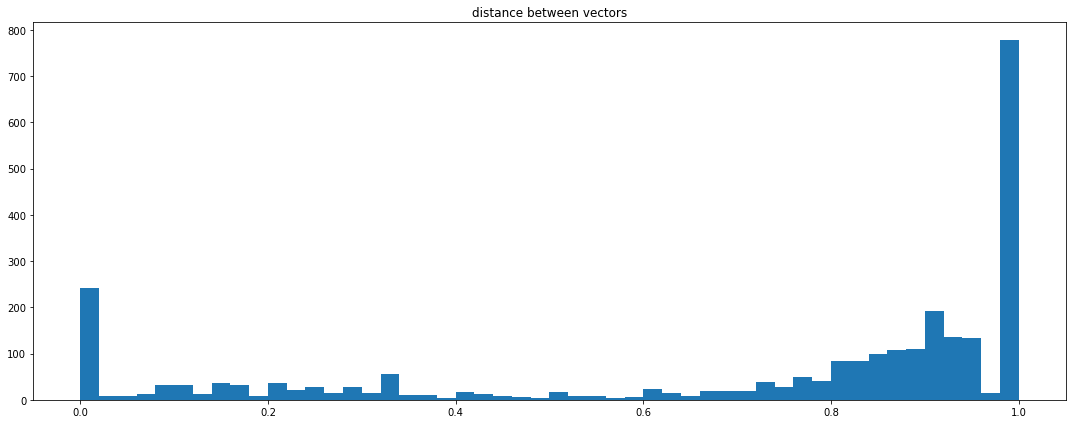

(array([241.,   8.,   8.,  13.,  31.,  33.,  13.,  37.,  33.,   9.,  36.,
        21.,  27.,  14.,  27.,  15.,  56.,  11.,  11.,   4.,  16.,  12.,
         9.,   6.,   3.,  16.,   9.,   8.,   3.,   5.,  23.,  14.,   8.,
        18.,  20.,  20.,  38.,  28.,  50.,  41.,  83.,  83.,  98., 108.,
       110., 192., 136., 133.,  15., 777.]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]), <a list of 50 Patch objects>)
0.02857142857142857 0.7815240975451689 1.0


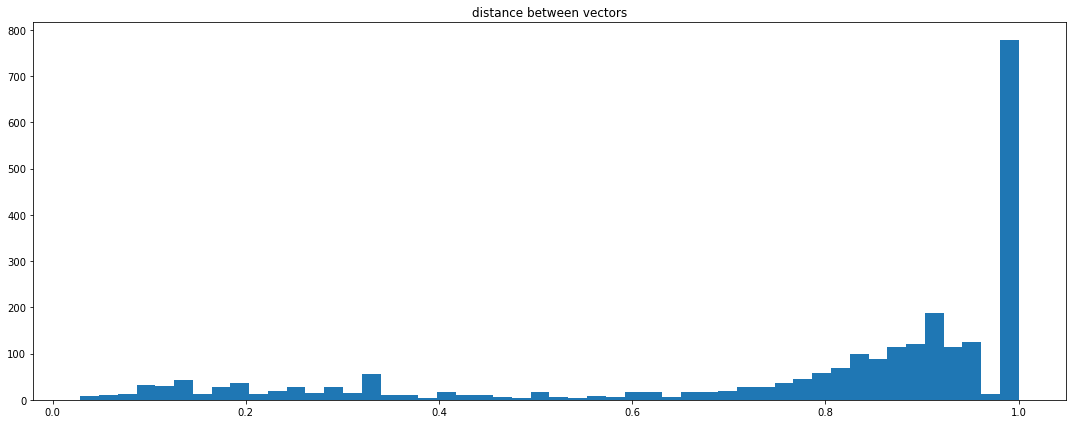

(array([  8.,  11.,  13.,  32.,  30.,  42.,  12.,  28.,  36.,  12.,  18.,
        27.,  15.,  27.,  14.,  56.,  11.,  11.,   4.,  16.,  11.,  10.,
         5.,   4.,  16.,   7.,   4.,   9.,   5.,  17.,  16.,   7.,  17.,
        17.,  19.,  28.,  27.,  37.,  44.,  59.,  68.,  99.,  88., 115.,
       121., 187., 115., 124.,  13., 777.]), array([0.02857143, 0.048     , 0.06742857, 0.08685714, 0.10628571,
       0.12571429, 0.14514286, 0.16457143, 0.184     , 0.20342857,
       0.22285714, 0.24228571, 0.26171429, 0.28114286, 0.30057143,
       0.32      , 0.33942857, 0.35885714, 0.37828571, 0.39771429,
       0.41714286, 0.43657143, 0.456     , 0.47542857, 0.49485714,
       0.51428571, 0.53371429, 0.55314286, 0.57257143, 0.592     ,
       0.61142857, 0.63085714, 0.65028571, 0.66971429, 0.68914286,
       0.70857143, 0.728     , 0.74742857, 0.76685714, 0.78628571,
       0.80571429, 0.82514286, 0.84457143, 0.864     , 0.88342857,
       0.90285714, 0.92228571, 0.94171429, 0.96114286, 0.98

In [12]:
ad = np.asarray(all_dists)
print(ad.min(), ad.mean(), ad.max())
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title("distance between vectors")
d = plt.hist(ad, bins=50)
plt.tight_layout()
plt.savefig(f'generation_distances_{gen}.png', dpi=150)
plt.show()
print(d)

nzad = ad[ad > 0]
print(nzad.min(), nzad.mean(), nzad.max())
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title("distance between vectors")
d = plt.hist(nzad, bins=50)
plt.tight_layout()
plt.savefig(f'nz_generation_distances_{gen}.png', dpi=150)
plt.show()
print(d)

In [ ]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title("Vector lengths")
d = plt.hist(all_lengths, bins=50)
plt.show()
print(d)

---
---
Random vector tests: 
---
Just create random output vectors and quantify maximum distances

In [ ]:

if bool(0):
    n_out = len(out_spikes)
    n_class = data['params']['sim']['num_classes']
    n_rest = n_class - 1

    n_trials = 100000
    max_distances = []
    vecs = []
    indices = set(range(n_out))
    used = set()
    available = set(range(n_out))
    for i in range(n_trials):
        vecs[:] = []
        used.clear()
        available.clear() 
        available |= set(range(n_out))
        for c in range(n_class):
            missing = n_class - c
            max_size = len(available) - (missing - 1)
            size = np.random.randint(0, max_size+1)
            ids = np.random.choice(list(available), size=size)
            v = np.zeros(n_out)
            v[ids] = 1
            vecs.append(v)
            used |= set(ids)
            available -= used

        max_distances.append(max_dist(vecs))

    # for win_length in np.arange(n_out-n_rest, 0, -1):
    #     rest = n_out - win_length
    #     n_on = rest // n_rest
    #     v0 = np.zeros(n_out)
    #     v0[:win_length] = 1

    #     distances.append(win_length + n_on)

    plt.figure()
    plt.hist(max_distances, bins=50)
    # plt.plot(distances)
    plt.show()
    #     print(n_out - win_length)

In [ ]:
max_d = float(n_out - n_class - 1)
md = np.clip(np.asarray(max_distances), 0, 220) / 220.# / np.exp(max_d)
md = np.asarray(max_distances)# / np.exp(max_d)
print(md.min(), md.mean(), md.max())

In [ ]:
plt.figure()
# plt.hist(np.asarray(max_distances)/max_d, bins=50)
plt.hist(md, bins=50)
# plt.plot(distances)
plt.show()
#     print(n_out - win_length)

In [ ]:
plt.figure()
plt.plot(sorted(np.clip(md, 0, 200)/200))
plt.show()

---
---
Random vector distance experiments:
---
Check what is the likely maximum distance for vectors in the output population

---
---

In [18]:
if bool(1):
    n_out = 280#len(out_spikes)
    n_class = 14#data['params']['sim']['num_classes']
    n_rest = n_class - 1

    n_trials = 50
    max_distances = {}
    vecs = []
    indices = set(range(n_out))
    used = set()
    available = set(range(n_out))
    samples = {}
    for prc in np.arange(1., 1.01, 0.1):
        mdd = []
        for i in range(n_trials):
            vecs[:] = []
            for c in range(n_class):
                max_size = int(n_out * prc)
                size = np.random.randint(0, max_size+1)
                size = min(size, len(available))
#                 size = max_size
                ids = np.random.choice(list(available), size=size, replace=False)
                v = np.zeros(n_out)
                v[ids] = 1
                vecs.append(v)
                slist = samples.get(size, [])
                slist.append(v)
                samples[size] = slist

            mdd.append(max_dist(vecs))
        max_distances[prc] = mdd

In [31]:
def _mdist(v0, v1, normalize=True):
    s = 0.
    if np.sum(v0) >= 1 and np.sum(v1) >= 1:
        s = np.logical_xor(
                np.asarray(v0), 
                np.asarray(v1)).sum()
        if normalize:
            sv0 = np.sum(v0)
            sv1 = np.sum(v1)
#             n = np.sqrt(sv0+sv1)
#             n = sv0 + sv1
            n = (max(sv0, sv1))#/min(sv0, sv1))
            s *= 1./n
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists[s0-min_s, s1-min_s] = np.mean(_ds)


0 280
280

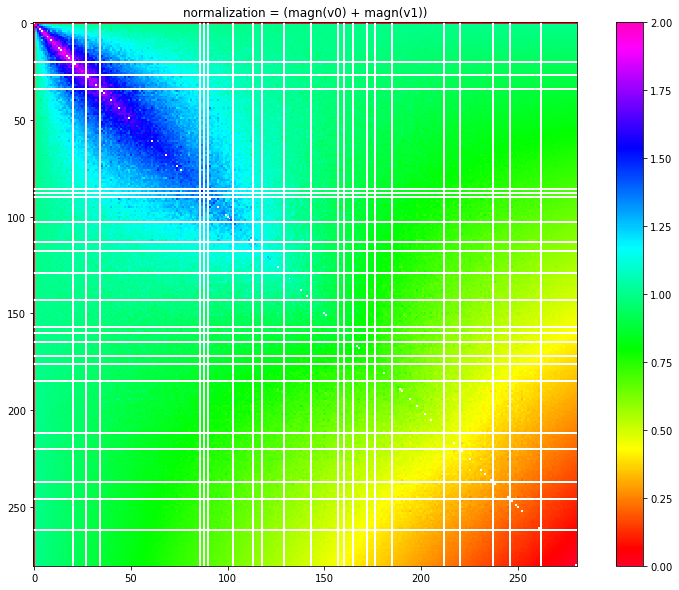

In [32]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('normalization = (magn(v0) + magn(v1))')
plt.imshow(dists, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.savefig('plot_magn_xor.png', dpi=150)
plt.show()


In [23]:
def _mdist(v0, v1, normalize=True):
    s = 0.
    if np.sum(v0) >= 1 and np.sum(v1) >= 1:
        s = np.sum(np.abs(v0 - v1))
        if normalize:
            s *= 1./(np.sum(v0) + np.sum(v1))
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists[s0-min_s, s1-min_s] = np.mean(_ds)


0 280
280

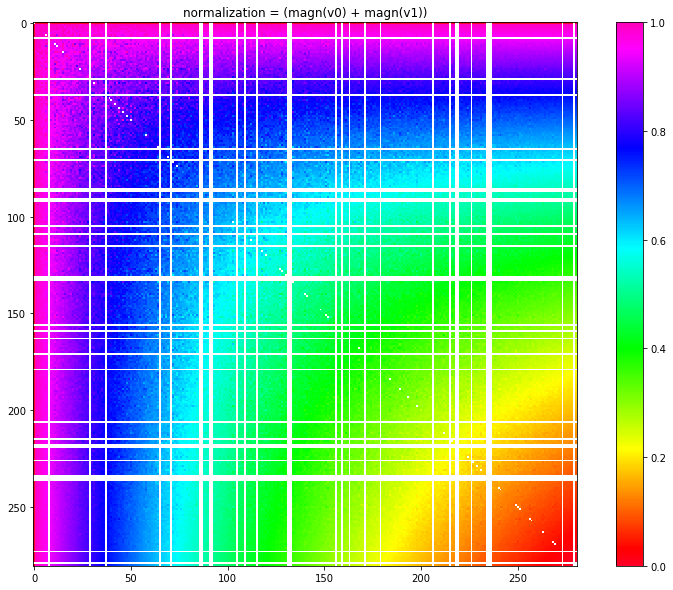

In [24]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('normalization = (magn(v0) + magn(v1))')
plt.imshow(dists, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.savefig('plot_magn_sum.png', dpi=150)
plt.show()


In [25]:
def _mdist(v0, v1, threshold=1,normalize=True):
    s = 0.
    if np.sum(v0) >= threshold and np.sum(v1) >= threshold:
        s = np.sum(np.abs(v0 - v1))
        if normalize:
            sv0 = np.sum(v0)
            sv1 = np.sum(v1)
#             n = np.sqrt(sv0+sv1)
            n = (max(sv0, sv1))#/min(sv0, sv1))
            s *= 1./n
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists_max = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1, 1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists_max[s0-min_s, s1-min_s] = np.mean(_ds)


0 280
280

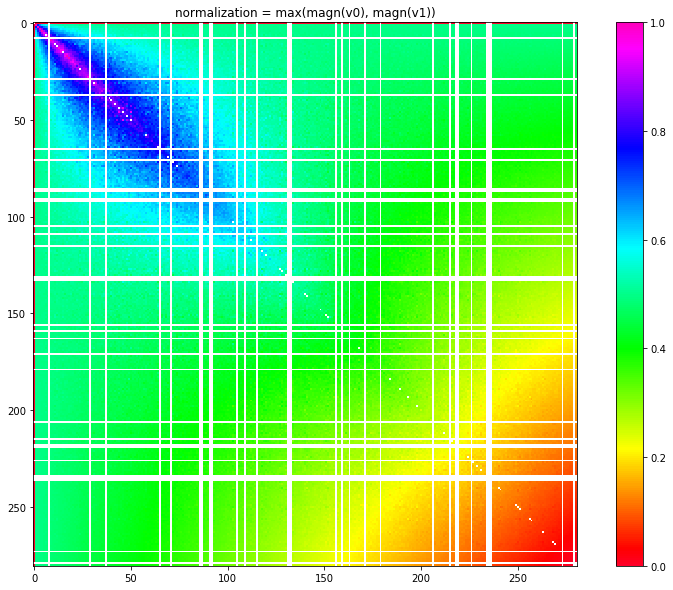

In [26]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('normalization = max(magn(v0), magn(v1))')
plt.imshow(dists_max/2, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.savefig('plot_magn_max.png', dpi=150)
plt.show()


In [27]:
def _mdist(v0, v1, threshold=1,normalize=True):
    s = 0.
    if np.sum(v0) >= threshold and np.sum(v1) >= threshold:
        n0 = np.sqrt(np.sum(v0**2))
        n1 = np.sqrt(np.sum(v1**2))
        dot = np.dot(v0/n0, v1/n1)
        c = dot# / (n0*n1)
        s = np.degrees(np.arccos(c))
#         s = c
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists_max = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1, 1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists_max[s0-min_s, s1-min_s] = np.mean(_ds)


0 280
280

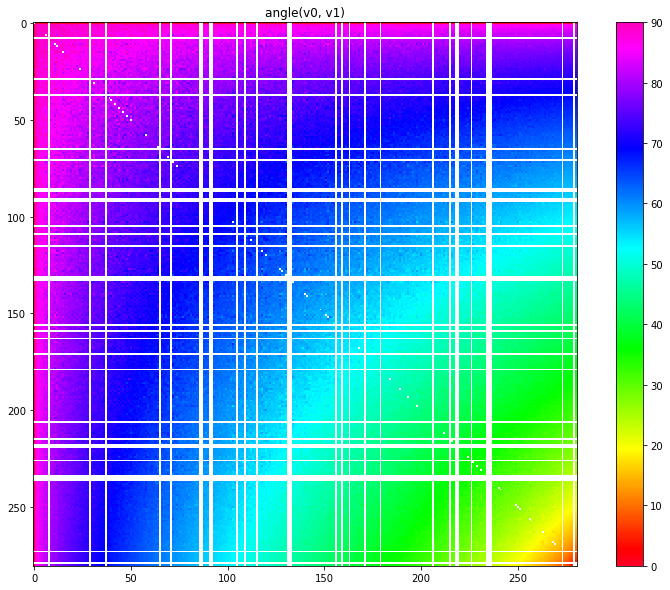

In [28]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('angle(v0, v1)')
plt.imshow(dists_max, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.savefig('plot_cos_dist.png', dpi=150)
plt.show()


In [ ]:
def _mdist(v0, v1, threshold=1,normalize=True):
    s = 0.
    if np.sum(v0) >= threshold and np.sum(v1) >= threshold:
        s = np.sqrt(np.sum((v0 - v1)**2))
    return s

sizes = sorted(samples.keys())
max_s = np.max(sizes)
min_s = np.min(sizes)
print(min_s, max_s)
n_sizes = max_s - min_s
dists_max = np.ones((n_sizes+1, n_sizes+1)) * np.nan
_ds = []
for s0 in sizes:
    sys.stdout.write(f"\r{s0}")
    sys.stdout.flush()

    for s1 in sizes:

        _ds[:] = [_mdist(v0, v1, 1)
                    for v0 in samples[s0] 
                        for v1 in samples[s1] if not np.all(v0==v1)]
        if len(_ds):
            dists_max[s0-min_s, s1-min_s] = np.mean(_ds)


In [ ]:
plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1)
ax.set_title('euclidean')
plt.imshow(dists_max, cmap='gist_rainbow', interpolation='none')
plt.colorbar()
plt.tight_layout()
plt.savefig('plot_euc_dist.png', dpi=150)
plt.show()


In [ ]:
# for win_length in np.arange(n_out-n_rest, 0, -1):
#     rest = n_out - win_length
#     n_on = rest // n_rest
#     v0 = np.zeros(n_out)
#     v0[:win_length] = 1
    
#     distances.append(win_length + n_on)
plt.figure(figsize=(15, 6))
for prc in max_distances:
#     plt.figure(figsize=(15, 6))
    plt.hist(max_distances[prc], bins=50, label=f"{prc:6.4f}", alpha=0.6)
# plt.plot(distances)
    plt.legend()
plt.show()
#     print(n_out - win_length)

In [15]:
def get_unique_distances(vectors):
    dists = []
    for i0, k0 in enumerate(vectors[:-1]):
        for k1 in vectors[i0+1:]:
#             print(np.sum(k0), np.sum(k1))
            if np.sum(k0) < 1 or np.sum(k1) < 1:
                s = 0.
            else:
                diff = np.abs(k0 - k1)
#                 print(k0, k1, diff)
                s = np.sum(diff)
            dists.append(s)
    return dists

if bool(1):
    all_distances = {}
    n_out = len(out_spikes)
    n_class = data['params']['sim']['num_classes']
    n_rest = n_class - 1

    n_trials = 1000
    max_distances = {}
    vecs = []
    indices = set(range(n_out))
    used = set()
    available = set(range(n_out))
    for prc in np.arange(0.1, 1.1, 0.1):
        ald = []
        mdd = []
        for i in range(n_trials):
            i += 1
            sys.stdout.write(f"\r{prc:4.2f} {i}/{n_trials}")
            sys.stdout.flush()
            vecs[:] = []
            for c in range(n_class):
                max_size = int(n_out * prc)
                size = np.random.randint(1, max_size+1)
#                 size = max_size
                ids = np.random.choice(list(available), size=size, replace=False)
                v = np.zeros(n_out)
                v[ids] = 1
                vecs.append(v)
#             print(vecs)
            
            ald += get_unique_distances(vecs)

            mdd.append(max_dist(vecs))
        sys.stdout.write(f"\n")
        sys.stdout.flush()
        
        all_distances[prc] = ald
        max_distances[prc] = mdd

0.10 1000/1000
0.20 795/1000

KeyboardInterrupt: 

In [ ]:
# for win_length in np.arange(n_out-n_rest, 0, -1):
#     rest = n_out - win_length
#     n_on = rest // n_rest
#     v0 = np.zeros(n_out)
#     v0[:win_length] = 1
    
#     distances.append(win_length + n_on)
plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 1, 1)
ax.set_title(f'Histograms of distances with maximum vector size')
for prc in all_distances:
#     plt.figure(figsize=(15, 6))
    pprc = int(100 * prc)
    plt.hist(all_distances[prc], bins=50, label=f"{pprc:d}%", alpha=0.6)
# plt.plot(distances)
    plt.legend()
ax.set_xlabel('Manhattan distance')
plt.tight_layout()
plt.savefig('distance_simulations_histograms.png', dpi=150)
plt.show()
#     print(n_out - win_length)

In [ ]:
print([np.mean(all_distances[x]) for x in all_distances])

In [ ]:
print([np.median(all_distances[x]) for x in all_distances])

In [ ]:
files = glob.glob('../titan/filtered_*.npz')
# files = sorted(glob.glob('../titan/filtered_*_data_*.npz'))
# filtered_mushroom_spikes_data_gen*
print(files)

In [ ]:
for f in files:
    with np.load(f, allow_pickle=True) as d:
        data = to_dict(d)
    print(f)
    s = data['spikes']
    n_neurons = len(s)
#     rand_ids = np.random.randint(n_neurons, size=1000)
    rand_ids = np.arange(n_neurons - 1000, n_neurons)
    plt.figure()
    for idx in rand_ids: 
        ts = s[idx]
        ttt = ts[ts < 1000.]
        plt.plot(ttt, idx * np.ones_like(ttt), '.b', markersize=3)
    
    fname = os.path.splitext(os.path.basename(f))[0]
    print(fname)
    plt.savefig(f'{fname:s}.png', dpi=150)
    plt.show()
        


In [13]:
x = np.arange(20)
p = np.clip(np.cos(x), 0., 1.)
print(p)
print(np.sum(p > 0))

[1.         0.54030231 0.         0.         0.         0.28366219
 0.96017029 0.75390225 0.         0.         0.         0.0044257
 0.84385396 0.90744678 0.13673722 0.         0.         0.
 0.66031671 0.98870462]
11


In [16]:
x = np.arange(20)
p = np.exp(-1/x)
print(p)
p = np.clip(p, 0., 1.)
print(p)
print(np.sum(p > 0))

[0.         0.36787944 0.60653066 0.71653131 0.77880078 0.81873075
 0.84648172 0.8668779  0.8824969  0.89483932 0.90483742 0.91310072
 0.92004441 0.92596108 0.93106278 0.93550699 0.93941306 0.94287314
 0.94595947 0.94872948]
[0.         0.36787944 0.60653066 0.71653131 0.77880078 0.81873075
 0.84648172 0.8668779  0.8824969  0.89483932 0.90483742 0.91310072
 0.92004441 0.92596108 0.93106278 0.93550699 0.93941306 0.94287314
 0.94595947 0.94872948]
19


<ipython-input-16-d58be299f1d5>:2: RuntimeWarning: divide by zero encountered in true_divide
  p = np.exp(-1/x)
